In [1]:
# Import libraries and modules
import sys
import tensorflow as tf
import numpy as np
import shutil
print(tf.__version__)
print(np.__version__)
np.set_printoptions(threshold = np.inf)

1.13.1
1.15.4


In [2]:
# tf.enable_eager_execution()
tf.executing_eagerly()

False

# Create data

## Create data generator

In [3]:
simple_data_genertator = False

percent_sequence_before_anomaly = 70.0
percent_sequence_after_anomaly = 0.0

def create_time_series_normal_parameters():
    normal_frequency_noise_scale = 1.0
    normal_frequence_noise_shift = 1.0

    normal_amplitude_noise_scale = 1.0
    normal_amplitude_noise_shift = 1.0

    normal_noise_noise_scale = 1.0

    if simple_data_genertator == True:
        normal_freq = 1.0
        normal_ampl = 1.0
    else:
        normal_freq = (np.random.random() * normal_frequency_noise_scale) + normal_frequence_noise_shift
        normal_ampl = np.random.random() * normal_amplitude_noise_scale + normal_amplitude_noise_shift
    
    return {"normal_freq": normal_freq, "normal_ampl": normal_ampl, "normal_noise_noise_scale": normal_noise_noise_scale}
  
def create_time_series_normal(
  number_of_sequences, 
  seq_len, 
  normal_freq, 
  normal_ampl, 
  normal_noise_noise_scale):
    # Normal parameters
    if simple_data_genertator == True:
        sequence = np.stack(
          arrays = [np.sin(np.arange(0, seq_len) * normal_freq) * normal_ampl 
                                      for _ in range(number_of_sequences)], axis = 0)
    else:
        sequence = np.stack(
          arrays = [np.sin(np.arange(0, seq_len) * normal_freq) * normal_ampl + \
                    [np.random.random() * normal_noise_noise_scale 
                     for i in range(seq_len)] for _ in range(number_of_sequences)], axis = 0)

    return sequence

def create_time_series_with_anomaly(
  number_of_sequences, 
  seq_len, 
  percent_sequence_before_anomaly, 
  percent_sequence_after_anomaly, 
  normal_freq, 
  normal_ampl, 
  normal_noise_noise_scale):
    seq_len_before_anomaly = int(seq_len * percent_sequence_before_anomaly / 100.0)
    seq_len_after_anomaly = int(seq_len * percent_sequence_after_anomaly / 100.0)
    seq_len_anomaly = seq_len - seq_len_before_anomaly - seq_len_after_anomaly

    # Anomalous parameters
    anomalous_amplitude_multipler_min = 8.0
    anomalous_amplitude_multipler_max = 20.0

    if simple_data_genertator == True:
        sequence_with_anomaly = np.stack(
          arrays = [np.sin(np.arange(0, seq_len) * normal_freq) * normal_ampl 
                    for _ in range(number_of_sequences)], axis = 0)
    else:
        sequence_with_anomaly = create_time_series_normal(
          number_of_sequences, seq_len, normal_freq, normal_ampl, normal_noise_noise_scale)
    sequence_with_anomaly[:, seq_len_before_anomaly:seq_len_before_anomaly + seq_len_anomaly] *= \
      ((anomalous_amplitude_multipler_max - anomalous_amplitude_multipler_min) * \
       np.random.random_sample([number_of_sequences, seq_len_anomaly]) + anomalous_amplitude_multipler_min) * \
      (np.random.randint(2, size = [number_of_sequences, seq_len_anomaly]) * -2 + 1)
    
    return sequence_with_anomaly

In [4]:
test_normal_parameters = create_time_series_normal_parameters()

/usr/local/lib/python3.5/dist-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


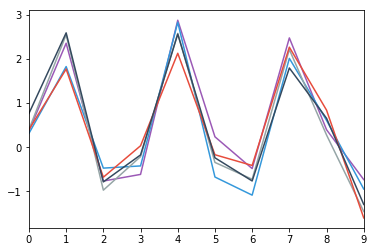

In [5]:
import seaborn as sns
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for i in range(0, 5):
    sns.tsplot(create_time_series_normal(1, 10, test_normal_parameters["normal_freq"], test_normal_parameters["normal_ampl"], test_normal_parameters["normal_noise_noise_scale"]).reshape(-1), color=flatui[i%len(flatui)] )

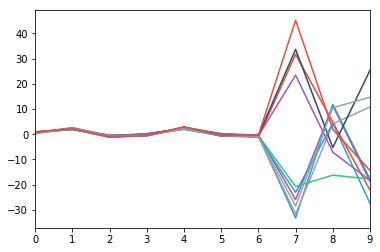

In [6]:
import seaborn as sns
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for i in range(0, 10):
    sns.tsplot(create_time_series_with_anomaly(1, 10, percent_sequence_before_anomaly, percent_sequence_after_anomaly, test_normal_parameters["normal_freq"], test_normal_parameters["normal_ampl"], test_normal_parameters["normal_noise_noise_scale"]).reshape(-1), color=flatui[i%len(flatui)] )

## Create training and evaluation data

In [7]:
number_of_training_normal_sequences = 64000

number_of_validation_normal_1_sequences = 6400
number_of_validation_normal_2_sequences = 6400
number_of_validation_anomalous_sequences = 6400

number_of_test_normal_sequences = 6400
number_of_test_anomalous_sequences = 6400

seq_len = 30
number_of_tags = 5
tag_columns = ["tag_{0}".format(tag) for tag in range(0, number_of_tags)]

In [8]:
tag_data_list = [create_time_series_normal_parameters() for tag in range(0, number_of_tags)]
tag_data_list

[{'normal_ampl': 1.934465318120246,
  'normal_freq': 1.901208744953395,
  'normal_noise_noise_scale': 1.0},
 {'normal_ampl': 1.190373292636073,
  'normal_freq': 1.8915345816227878,
  'normal_noise_noise_scale': 1.0},
 {'normal_ampl': 1.5614989831614847,
  'normal_freq': 1.8973473286135212,
  'normal_noise_noise_scale': 1.0},
 {'normal_ampl': 1.3329501129350887,
  'normal_freq': 1.2779262791765338,
  'normal_noise_noise_scale': 1.0},
 {'normal_ampl': 1.576957716486461,
  'normal_freq': 1.3585024404093535,
  'normal_noise_noise_scale': 1.0}]

In [9]:
# Create training set using normal sequences
training_normal_sequences_list = [create_time_series_normal(number_of_training_normal_sequences, seq_len, tag["normal_freq"], tag["normal_ampl"], tag["normal_noise_noise_scale"]) for tag in tag_data_list]
training_normal_sequences_array = np.stack(arrays = list(map(lambda i: np.stack(arrays = list(map(lambda j: np.array2string(a = training_normal_sequences_list[i][j], separator = ',').replace('[', '').replace(']', '').replace(' ', '').replace('\n', ''), np.arange(0, number_of_training_normal_sequences))), axis = 0), np.arange(0, number_of_tags))), axis = 1)
np.random.shuffle(training_normal_sequences_array)
print("training_normal_sequences_array.shape = \n{}".format(training_normal_sequences_array.shape))

training_normal_sequences_array.shape = 
(64000, 5)


In [10]:
# Create validation sets
# Create set vn1 of normal sequences which will be used for early stopping during training as well as using the error vectors to learn mu and sigma for mahalanobis distance
validation_normal_1_sequences_list = [create_time_series_normal(number_of_validation_normal_1_sequences, seq_len, tag["normal_freq"], tag["normal_ampl"], tag["normal_noise_noise_scale"]) for tag in tag_data_list]
validation_normal_1_sequences_array = np.stack(arrays = list(map(lambda i: np.stack(arrays = list(map(lambda j: np.array2string(a = validation_normal_1_sequences_list[i][j], separator = ',').replace('[', '').replace(']', '').replace(' ', '').replace('\n', ''), np.arange(0, number_of_validation_normal_1_sequences))), axis = 0), np.arange(0, number_of_tags))), axis = 1)
print("validation_normal_1_sequences_array.shape = \n{}".format(validation_normal_1_sequences_array.shape))

# Create set vn2 of normal sequences which will be used for tuning the anomaly thresholds
validation_normal_2_sequences_list = [create_time_series_normal(number_of_validation_normal_2_sequences, seq_len, tag["normal_freq"], tag["normal_ampl"], tag["normal_noise_noise_scale"]) for tag in tag_data_list]
validation_normal_2_sequences_array = np.stack(arrays = list(map(lambda i: np.stack(arrays = list(map(lambda j: np.array2string(a = validation_normal_2_sequences_list[i][j], separator = ',').replace('[', '').replace(']', '').replace(' ', '').replace('\n', ''), np.arange(0, number_of_validation_normal_2_sequences))), axis = 0), np.arange(0, number_of_tags))), axis = 1)
print("validation_normal_2_sequences_array.shape = \n{}".format(validation_normal_2_sequences_array.shape))

# Create set va of anomalous sequences which will be used for tuning the anomaly thresholds
validation_anomalous_sequences_list = [create_time_series_with_anomaly(number_of_validation_anomalous_sequences, seq_len, percent_sequence_before_anomaly, percent_sequence_after_anomaly, tag["normal_freq"], tag["normal_ampl"], tag["normal_noise_noise_scale"]) for tag in tag_data_list]
validation_anomalous_sequences_array = np.stack(arrays = list(map(lambda i: np.stack(arrays = list(map(lambda j: np.array2string(a = validation_anomalous_sequences_list[i][j], separator = ',').replace('[', '').replace(']', '').replace(' ', '').replace('\n', ''), np.arange(0, number_of_validation_anomalous_sequences))), axis = 0), np.arange(0, number_of_tags))), axis = 1)
print("validation_anomalous_sequences_array.shape = \n{}".format(validation_anomalous_sequences_array.shape))

validation_normal_1_sequences_array.shape = 
(6400, 5)
validation_normal_2_sequences_array.shape = 
(6400, 5)
validation_anomalous_sequences_array.shape = 
(6400, 5)


In [11]:
# Create test sets
# Create set tn of normal sequences which will be used for testing model
test_normal_sequences_list = [create_time_series_normal(number_of_test_normal_sequences, seq_len, tag["normal_freq"], tag["normal_ampl"], tag["normal_noise_noise_scale"]) for tag in tag_data_list]
test_normal_sequences_array = np.stack(arrays = list(map(lambda i: np.stack(arrays = list(map(lambda j: np.array2string(a = test_normal_sequences_list[i][j], separator = ',').replace('[', '').replace(']', '').replace(' ', '').replace('\n', ''), np.arange(0, number_of_test_normal_sequences))), axis = 0), np.arange(0, number_of_tags))), axis = 1)
print("test_normal_sequences_array.shape = \n{}".format(test_normal_sequences_array.shape))

# Create set ta of anomalous sequences which will be used for testing model
test_anomalous_sequences_list = [create_time_series_with_anomaly(number_of_test_anomalous_sequences, seq_len, percent_sequence_before_anomaly, percent_sequence_after_anomaly, tag["normal_freq"], tag["normal_ampl"], tag["normal_noise_noise_scale"]) for tag in tag_data_list]
test_anomalous_sequences_array = np.stack(arrays = list(map(lambda i: np.stack(arrays = list(map(lambda j: np.array2string(a = test_anomalous_sequences_list[i][j], separator = ',').replace('[', '').replace(']', '').replace(' ', '').replace('\n', ''), np.arange(0, number_of_test_anomalous_sequences))), axis = 0), np.arange(0, number_of_tags))), axis = 1)
print("test_anomalous_sequences_array.shape = \n{}".format(test_anomalous_sequences_array.shape))

test_normal_sequences_array.shape = 
(6400, 5)
test_anomalous_sequences_array.shape = 
(6400, 5)


In [12]:
# Combine vn2 and va sets for tuning anomaly thresholds
labeled_validation_normal_2_sequences_array = np.concatenate(seq = [validation_normal_2_sequences_array, np.zeros(shape = [validation_normal_2_sequences_array.shape[0], 1], dtype = np.int64)], axis = 1)
labeled_validation_anomalous_sequences_array = np.concatenate(seq = [validation_anomalous_sequences_array, np.ones(shape = [validation_anomalous_sequences_array.shape[0], 1], dtype = np.int64)], axis = 1)
labeled_validation_mixed_sequences_array = np.concatenate(seq = [labeled_validation_normal_2_sequences_array, labeled_validation_anomalous_sequences_array], axis = 0)
np.random.shuffle(labeled_validation_mixed_sequences_array)
print("labeled_validation_mixed_sequences_array.shape = \n{}".format(labeled_validation_mixed_sequences_array.shape))

# Combine tn and ta sets for testing model
labeled_test_normal_sequences_array = np.concatenate(seq = [test_normal_sequences_array, np.zeros(shape = [test_normal_sequences_array.shape[0], 1], dtype = np.int64)], axis = 1)
labled_test_anomalous_sequences_array = np.concatenate(seq = [test_anomalous_sequences_array, np.ones(shape = [test_anomalous_sequences_array.shape[0], 1], dtype = np.int64)], axis = 1)
labeled_test_mixed_sequences_array = np.concatenate(seq = [labeled_test_normal_sequences_array, labled_test_anomalous_sequences_array], axis = 0)
np.random.shuffle(labeled_test_mixed_sequences_array)
print("labeled_test_mixed_sequences_array.shape = \n{}".format(labeled_test_mixed_sequences_array.shape))

labeled_validation_mixed_sequences_array.shape = 
(12800, 6)
labeled_test_mixed_sequences_array.shape = 
(12800, 6)


In [13]:
np.savetxt(fname = "data/training_normal_sequences.csv", X = training_normal_sequences_array, fmt = '%s', delimiter = ";")

np.savetxt(fname = "data/validation_normal_1_sequences.csv", X = validation_normal_1_sequences_array, fmt = '%s', delimiter = ";")
np.savetxt(fname = "data/labeled_validation_mixed_sequences.csv", X = labeled_validation_mixed_sequences_array, fmt = '%s', delimiter = ";")

np.savetxt(fname = "data/labeled_test_mixed_sequences.csv", X = labeled_test_mixed_sequences_array, fmt = '%s', delimiter = ";")

In [14]:
!head -3 data/training_normal_sequences.csv

0.39858355,2.65254363,-0.22440989,-0.40623741,2.75324861,0.57108548,-0.89243439,1.88002762,1.10331612,-0.93450139,0.37056568,2.64908919,-1.0046694,-0.2079882,2.1309653,-0.36383995,-0.90830687,1.61912064,1.33396245,-1.17422966,0.63105182,2.50145432,-0.67844246,0.44652938,2.76062836,0.02286444,-0.83573397,1.76348491,1.0483393,-1.39752078;0.52953524,1.16938946,-0.52436196,-0.00698831,1.71230273,0.93820116,-0.23193446,1.30551717,1.1545876,-0.21651971,0.69701401,2.05938818,-0.70399574,-0.22676718,1.32977297,0.13032511,-0.96048387,1.15316998,0.96755109,-0.81041971,0.22402158,1.77408231,0.05911469,0.38773618,1.66773616,0.65385202,-0.64578626,1.76190019,1.42087456,-0.22876649;0.46444388,2.32641491,-0.09578211,-0.79550603,2.02746673,0.07559876,-1.01779293,1.73935032,1.39061809,-0.66830691,0.54046876,2.3031331,-0.22688819,0.04225882,2.53348412,0.17424398,-0.57728189,1.76089766,1.05684016,-1.25205258,0.72429686,1.38991973,-0.59040388,0.31089568,2.55323891,0.43834587,-0.88118161,1.92788581,0.49101

In [15]:
!head -3 data/validation_normal_1_sequences.csv

0.06582817,2.58766112,-0.88949998,-0.45486125,2.25908317,0.12560496,-1.54318392,2.01599298,1.32828277,-1.24265141,0.78402678,2.43285379,-1.19858225,-0.62189353,2.5238795,0.28468602,-0.81921495,1.5512089,1.17813508,-1.67093707,1.34500975,2.28789301,-0.91176601,0.48619149,2.43209966,-0.32436613,-1.3267261,2.55665496,1.13195035,-1.28367181;0.674755,1.20669086,-0.31642363,0.26987233,1.53749289,0.49789107,-0.80073191,1.7289013,1.29683625,-0.41062049,0.56723296,1.80089581,0.08090869,0.24694384,1.74567739,0.30503019,-1.00778158,1.12837276,1.36653572,-0.22431119,1.00885268,1.41554614,-0.47163904,0.27399521,1.4585749,0.23428618,-0.90093734,1.77319416,1.40910188,-1.01158949;0.01040907,2.26567815,0.04118448,-0.57051743,1.78442953,0.50908351,-1.41677797,1.50386105,1.1576121,-0.64494656,0.56715611,2.3148596,-0.32694192,-0.48255855,1.54950146,0.59111287,-1.22163493,2.11749362,1.18691862,-0.8248516,0.69926309,1.88712912,-0.92439509,-0.45566193,2.29855215,-0.06328181,-0.47089381,1.78501372,0.93724178,

In [16]:
!head -3 data/labeled_validation_mixed_sequences.csv

0.09686681,2.21977705,-0.51309167,-0.96712342,2.53653689,0.34290962,-1.52939205,2.19270784,1.40404278,-0.93508493,0.97214221,2.44837998,-0.88765644,-0.15889778,2.17726348,0.19580907,-1.0729981,1.96745227,1.37934906,-0.94129904,0.70362521,-42.42967198,12.4456772,3.25352641,-32.29992009,-0.19417063,-10.02674214,41.89685145,-8.77844889,14.01222273;0.778813,1.63867924,0.21281133,-0.04750577,1.91416793,0.40329681,-0.83545582,1.1517538,1.34352399,-0.74520664,0.19588877,1.18739871,-0.08112074,0.07505905,1.29728397,0.82771885,-0.85499446,1.49221143,0.79350753,-1.04894498,0.90250631,16.63771653,-13.86608913,3.1176585,19.26375037,6.51099408,8.12971361,13.54421434,12.90208473,5.6377095;3.42531869e-01,2.08486361e+00,-2.97398820e-01,-4.33087518e-01,1.93249336e+00,-2.82147652e-02,-1.01597754e+00,1.82032722e+00,9.88551064e-01,-1.52892810e+00,4.62740690e-01,1.46242291e+00,-8.12539975e-01,-5.66425712e-01,1.76024456e+00,1.32331550e-01,-1.11934139e+00,1.53014663e+00,1.59426728e+00,-7.79228745e-01,9.04786

In [17]:
!head -3 data/labeled_test_mixed_sequences.csv

0.69086149,1.84653047,-0.27579564,-0.96045266,2.51238931,0.5193846,-0.81167276,1.7126831,1.50240691,-1.82734892,1.00048179,1.94429436,-0.47270502,0.15593438,2.16550661,-0.21401734,-1.04229361,1.89536358,1.59519094,-1.91937034,1.51238207,2.25271102,-0.76355597,-0.38580618,2.12494178,-0.05189493,-1.30890929,2.41145904,0.97370606,-1.40760436;0.0816461,1.69923258,-0.26975399,-0.01740842,1.47744574,0.6024875,-0.25156123,1.53827676,1.58594125,-0.62442017,0.262161,1.24635002,-0.59603712,-0.34755601,1.80871231,0.29950957,-1.01058089,1.7763477,1.40076985,-0.5125879,0.49035114,2.06000579,-0.7742204,-0.36909696,1.85735994,0.51273467,-0.88909358,1.48550297,0.91255466,-0.33070312;0.10232743,2.39325643,-0.03081317,-0.84963955,2.26490536,0.50324991,-1.15428092,1.28568023,0.94097331,-1.27767991,1.05340571,2.15517644,-0.5059351,-0.64548033,2.20855061,0.50472434,-1.12141317,1.53234642,1.13868716,-1.19444708,0.8261017,1.92178486,-0.48273688,-0.20736948,2.07050118,-0.17539943,-0.51884901,1.89904968,1.1423

# Local Development

In [18]:
# Set logging to be level of INFO
tf.logging.set_verbosity(tf.logging.INFO)

In [19]:
# Determine CSV and label columns
UNLABELED_CSV_COLUMNS = tag_columns

LABEL_COLUMN = "anomalous_sequence_flag"
LABELED_CSV_COLUMNS = UNLABELED_CSV_COLUMNS + [LABEL_COLUMN]

# Set default values for each CSV column
UNLABELED_DEFAULTS = [[""] for _ in UNLABELED_CSV_COLUMNS]

LABELED_DEFAULTS = UNLABELED_DEFAULTS + [[0.0]]

In [20]:
# Create an input function reading a file using the Dataset API
# Then provide the results to the Estimator API
def read_dataset(filename, mode, batch_size, params):
    def _input_fn():
        def decode_csv(value_column, seq_len):
            def convert_sequences_from_strings_to_floats(features, column_list):
                def split_and_convert_string(string_tensor):
                    # Split string tensor into a sparse tensor based on delimiter
                    split_string = tf.string_split(source = tf.expand_dims(input = string_tensor, axis = 0), delimiter = ",")

                    # Converts the values of the sparse tensor to floats
                    converted_tensor = tf.string_to_number(split_string.values, out_type = tf.float64)

                    # Create a new sparse tensor with the new converted values, because the original sparse tensor values are immutable
                    new_sparse_tensor = tf.SparseTensor(indices = split_string.indices, values = converted_tensor, dense_shape = split_string.dense_shape)

                    # Create a dense tensor of the float values that were converted from text csv
                    dense_floats = tf.sparse_tensor_to_dense(sp_input = new_sparse_tensor, default_value = 0.0)

                    dense_floats_vector = tf.squeeze(input = dense_floats, axis = 0)

                    return dense_floats_vector
                    
                for column in column_list:
                    features[column] = split_and_convert_string(features[column])
                    features[column].set_shape([seq_len])

                return features
                
            if mode == tf.estimator.ModeKeys.TRAIN or (mode == tf.estimator.ModeKeys.EVAL and params["evaluation_mode"] != "tune_anomaly_thresholds"):
                columns = tf.decode_csv(records = value_column, record_defaults = UNLABELED_DEFAULTS, field_delim = ";")
                features = dict(zip(UNLABELED_CSV_COLUMNS, columns))
                features = convert_sequences_from_strings_to_floats(features, UNLABELED_CSV_COLUMNS)
                return features
            else:
                columns = tf.decode_csv(records = value_column, record_defaults = LABELED_DEFAULTS, field_delim = ";")
                features = dict(zip(LABELED_CSV_COLUMNS, columns))
                labels = tf.cast(x = features.pop(LABEL_COLUMN), dtype = tf.float64)
                features = convert_sequences_from_strings_to_floats(features, LABELED_CSV_COLUMNS[0:-1])
                return features, labels
        
        # Create list of files that match pattern
        file_list = tf.gfile.Glob(filename = filename)

        # Create dataset from file list
        dataset = tf.data.TextLineDataset(filenames = file_list)    # Read text file

        # Decode the CSV file into a features dictionary of tensors
        dataset = dataset.map(map_func = lambda x: decode_csv(x, params["seq_len"]))
        
        # Determine amount of times to repeat file based on if we are training or evaluating
        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = None # indefinitely
        else:
            num_epochs = 1 # end-of-input after this

        # Repeat files num_epoch times
        dataset = dataset.repeat(count = num_epochs)

        # Group the data into batches
        dataset = dataset.batch(batch_size = batch_size)
        
        # Determine if we should shuffle based on if we are training or evaluating
        if mode == tf.estimator.ModeKeys.TRAIN:
            dataset = dataset.shuffle(buffer_size = 10 * batch_size)

        # Create a iterator and then pull the next batch of features from the example queue
        batched_dataset = dataset.make_one_shot_iterator().get_next()

        return batched_dataset
    return _input_fn

In [21]:
def try_out_input_function():
    with tf.Session() as sess:
        fn = read_dataset(
          filename = "data/labeled_validation_mixed_sequences.csv",
          mode = tf.estimator.ModeKeys.EVAL,
          batch_size = 8,
          params = {"seq_len": seq_len,
                    "evaluation_mode": "tune_anomaly_thresholds"})

        features = sess.run(fn())
        print("try_out_input_function: features = \n{}".format(features))

#         print("try_out_input_function: features[tag_0].shape = {}".format(features["tag_0"].shape))

In [22]:
# try_out_input_function()

In [23]:
def create_LSTM_stack(lstm_hidden_units, lstm_dropout_output_keep_probs):
    # First create a list of LSTM cells using our list of lstm hidden unit sizes
    lstm_cells = [tf.contrib.rnn.BasicLSTMCell(num_units = units, forget_bias = 1.0, state_is_tuple = True) for units in lstm_hidden_units] # list of LSTM cells

    # Next apply a dropout wrapper to our stack of LSTM cells, in this case just on the outputs
    dropout_lstm_cells = [tf.nn.rnn_cell.DropoutWrapper(
        cell = lstm_cells[cell_index], 
        input_keep_prob = 1.0, 
        output_keep_prob = lstm_dropout_output_keep_probs[cell_index], 
        state_keep_prob = 1.0) for cell_index in range(len(lstm_cells))]

    # Create a stack of layers of LSTM cells
    stacked_lstm_cells = tf.contrib.rnn.MultiRNNCell(
        cells = dropout_lstm_cells, state_is_tuple = True) # combines list into MultiRNNCell object

    return stacked_lstm_cells

In [24]:
# The rnn_decoder function takes labels during TRAIN/EVAL and a start token followed by its previous predictions during PREDICT
# Starts with an intial state of the final encoder states
def rnn_decoder(decoder_inputs, initial_state, cell, inference, dnn_hidden_units, num_features):
    # Create the decoder variable scope
    with tf.variable_scope("decoder"):
        # Load in our initial state from our encoder
        state = initial_state # tuple of final encoder c_state and h_state of final encoder layer

        # Create an empty list to store our hidden state output for every timestep
        outputs = []

        # Begin with no previous output
        previous_output = None

        # Loop over all of our decoder_inputs which will be seq_len long
        for index, decoder_input in enumerate(decoder_inputs):
            # If there has been a previous output then we will determine the next input
            if previous_output is not None:
                # Create the input layer to our DNN
                network = previous_output # shape = (current_batch_size, lstm_hidden_units[-1])

                # Create our dnn variable scope
                with tf.variable_scope(name_or_scope = "dnn", reuse = tf.AUTO_REUSE):
                    # Add hidden layers with the given number of units/neurons per layer
                    for units in dnn_hidden_units:
                        network = tf.layers.dense(
                            inputs = network, 
                            units = units, 
                            activation = tf.nn.relu) # shape = (current_batch_size, dnn_hidden_units[i])

                    # Connect the final hidden layer to a dense layer with no activation to get the logits
                    logits = tf.layers.dense(
                        inputs = network, 
                        units = num_features, 
                        activation = None) # shape = (current_batch_size, num_features)

                # If we are in inference then we will overwrite our next decoder_input with the logits we just calculated.
                # Otherwise, we leave the decoder_input input as it was from the enumerated list
                # We have to calculate the logits even when not using them so that the correct dnn subgraph will be generated here and after the encoder-decoder for both training and inference
                if inference == True:
                    decoder_input = logits # shape = (current_batch_size, num_features)

            # If this isn"t our first time through the loop, just reuse(share) the same variables for each iteration within the current variable scope
            if index > 0:
                tf.get_variable_scope().reuse_variables()

            # Run the decoder input through the decoder stack picking up from the previous state
            output, state = cell(decoder_input, state) # output = shape = (current_batch_size, lstm_hidden_units[-1]), state = # tuple of final decoder c_state and h_state

            # Append the current decoder hidden state output to the outputs list
            outputs.append(output) # growing list eventually seq_len long of shape = (current_batch_size, lstm_hidden_units[-1])

            # Set the previous output to the output just calculated
            previous_output = output # shape = (current_batch_size, lstm_hidden_units[-1])
    return outputs, state

In [25]:
# This function updates the count of records used
def update_count(count_a, count_b):
  return count_a + count_b

# This function updates the mahalanobis distance variables when the number_of_rows equals 1
def singleton_batch_mahalanobis_distance_variable_updating(
  inner_size, 
  X, 
  count_variable, 
  mean_variable, 
  covariance_matrix_variable, 
  inverse_covariance_matrix_variable,
  eps):
  # This function updates the mean vector incrementally
  def update_mean_incremental(count_a, mean_a, value_b):
    mean_ab = (mean_a * tf.cast(x = count_a, dtype = tf.float64) + \
           tf.squeeze(input = value_b, axis = 0)) / tf.cast(x = count_a + 1, dtype = tf.float64)
    return mean_ab

  # This function updates the covariance matrix incrementally
  def update_covariance_incremental(count_a, mean_a, cov_a, value_b, mean_ab, sample_covariance):
    if sample_covariance == True:
      cov_ab = (cov_a * tf.cast(x = count_a - 1, dtype = tf.float64) + \
            tf.matmul(a = value_b - mean_a, b = value_b - mean_ab, transpose_a = True)) \
        / tf.cast(x = count_a, dtype = tf.float64)
    else:
      cov_ab = (cov_a * tf.cast(x = count_a, dtype = tf.float64) + \
            tf.matmul(a = value_b - mean_a, b = value_b - mean_ab, transpose_a = True)) \
        / tf.cast(x = count_a + 1, dtype = tf.float64)
    return cov_ab

  # Calculate new combined mean to use for incremental covariance matrix calculation
  mean_ab = update_mean_incremental(
    count_a = count_variable, 
    mean_a = mean_variable, 
    value_b = X) # time_shape = (num_features,), features_shape = (sequence_length,)

  # Update running variables from single example
  count_tensor = update_count(
    count_a = count_variable, 
    count_b = 1) # time_shape = (), features_shape = ()

  mean_tensor = mean_ab # time_shape = (num_features,), features_shape = (sequence_length,)

  if inner_size == 1:
    covariance_matrix_tensor = tf.zeros_like(
      tensor = covariance_matrix_variable, dtype = tf.float64)
    inverse_covariance_matrix_tensor = tf.eye(
      num_rows = tf.shape(
        input = covariance_matrix_tensor)[0], 
        dtype = tf.float64) / eps
  else:
    covariance_matrix_tensor = update_covariance_incremental(
      count_a = count_variable, 
      mean_a = mean_variable, 
      cov_a = covariance_matrix_variable, 
      value_b = X, 
      mean_ab = mean_ab, 
      sample_covariance = True) # time_shape = (num_features, num_features), features_shape = (sequence_length, sequence_length)

    inverse_covariance_matrix_tensor = tf.matrix_inverse(
      input = covariance_matrix_tensor + tf.eye(
        num_rows = tf.shape(
          input = covariance_matrix_tensor)[0], 
          dtype = tf.float64) * eps) # time_shape = (num_features, num_features), features_shape = (sequence_length, sequence_length)

  # Assign values to variables, use control dependencies around return to enforce the mahalanobis variables to be assigned, the control order matters, hence the separate contexts
  with tf.control_dependencies(
    control_inputs = [tf.assign(
      ref = covariance_matrix_variable, 
      value = covariance_matrix_tensor)]):
    with tf.control_dependencies(
      control_inputs = [tf.assign(
        ref = mean_variable, 
        value = mean_tensor)]):
      with tf.control_dependencies(
        control_inputs = [tf.assign(
          ref = count_variable, 
          value = count_tensor)]):
        with tf.control_dependencies(
          control_inputs = [tf.assign(
            ref = inverse_covariance_matrix_variable, 
            value = inverse_covariance_matrix_tensor)]):
          return tf.identity(input = covariance_matrix_variable), tf.identity(input = mean_variable), tf.identity(input = count_variable), tf.identity(input = inverse_covariance_matrix_variable)

# This function updates the mahalanobis distance variables when the number_of_rows does NOT equal 1
def non_singleton_batch_mahalanobis_distance_variable_updating(
  cur_batch_size, 
  inner_size, 
  X, 
  count_variable, 
  mean_variable, 
  covariance_matrix_variable, 
  inverse_covariance_matrix_variable,
  eps):
  # This function updates the mean vector using a batch of data
  def update_mean_batch(count_a, mean_a, count_b, mean_b):
    mean_ab = (mean_a * tf.cast(x = count_a, dtype = tf.float64) + mean_b * tf.cast(x = count_b, dtype = tf.float64)) / tf.cast(x = count_a + count_b, dtype = tf.float64)
    return mean_ab

  # This function updates the covariance matrix using a batch of data
  def update_covariance_batch(count_a, mean_a, cov_a, count_b, mean_b, cov_b, sample_covariance):
    mean_diff = tf.expand_dims(input = mean_a - mean_b, axis = 0)

    if sample_covariance == True:
      cov_ab = (cov_a * tf.cast(x = count_a - 1, dtype = tf.float64) + cov_b * tf.cast(x = count_b - 1, dtype = tf.float64) + \
            tf.matmul(a = mean_diff, b = mean_diff, transpose_a = True) * tf.cast(x = count_a * count_b, dtype = tf.float64) \
            / tf.cast(x = count_a + count_b, dtype = tf.float64)) / tf.cast(x = count_a + count_b - 1, dtype = tf.float64)
    else:
      cov_ab = (cov_a * tf.cast(x = count_a, dtype = tf.float64) + cov_b * tf.cast(x = count_b, dtype = tf.float64) + \
            tf.matmul(a = mean_diff, b = mean_diff, transpose_a = True) * tf.cast(x = count_a * count_b, dtype = tf.float64) \
            / tf.cast(x = count_a + count_b, dtype = tf.float64)) / tf.cast(x = count_a + count_b, dtype = tf.float64)
    return cov_ab          

  # Find statistics of batch
  number_of_rows = cur_batch_size * inner_size

  X_mean = tf.reduce_mean(input_tensor = X, axis = 0) # time_shape = (num_features,), features_shape = (sequence_length,)

  X_centered = X - X_mean # time_shape = (cur_batch_size * sequence_length, num_features), features_shape = (cur_batch_size * num_features, sequence_length)

  if inner_size > 1:
    X_covariance_matrix = tf.matmul(
      a = X_centered,
      b = X_centered, 
      transpose_a = True) / tf.cast(x = number_of_rows - 1, dtype = tf.float64) # time_shape = (num_features, num_features), features_shape = (sequence_length, sequence_length)

  # Update running variables from batch statistics
  count_tensor = update_count(
    count_a = count_variable, 
    count_b = number_of_rows) # time_shape = (), features_shape = ()

  mean_tensor = update_mean_batch(
    count_a = count_variable, 
    mean_a = mean_variable, 
    count_b = number_of_rows, 
    mean_b = X_mean) # time_shape = (num_features,), features_shape = (sequence_length,)

  if inner_size == 1:
    covariance_matrix_tensor = tf.zeros_like(tensor = covariance_matrix_variable, dtype = tf.float64)
    inverse_covariance_matrix_tensor = tf.eye(num_rows = tf.shape(input = covariance_matrix_tensor)[0], 
                                           dtype = tf.float64) / eps
  else:
    covariance_matrix_tensor = update_covariance_batch(
      count_a = count_variable, 
      mean_a = mean_variable, 
      cov_a = covariance_matrix_variable, 
      count_b = number_of_rows, 
      mean_b = X_mean, 
      cov_b = X_covariance_matrix, 
      sample_covariance = True) # time_shape = (num_features, num_features), features_shape = (sequence_length, sequence_length)

    inverse_covariance_matrix_tensor = tf.matrix_inverse(
      input = covariance_matrix_tensor + \
      tf.eye(num_rows = tf.shape(input = covariance_matrix_tensor)[0], 
      dtype = tf.float64) * eps) # time_shape = (num_features, num_features), features_shape = (sequence_length, sequence_length)

  # Assign values to variables, use control dependencies around return to enforce the mahalanobis variables to be assigned, the control order matters, hence the separate contexts
  with tf.control_dependencies(
    control_inputs = [tf.assign(ref = covariance_matrix_variable, value = covariance_matrix_tensor)]):
    with tf.control_dependencies(
      control_inputs = [tf.assign(ref = mean_variable, value = mean_tensor)]):
      with tf.control_dependencies(
        control_inputs = [tf.assign(ref = count_variable, value = count_tensor)]):
        with tf.control_dependencies(
          control_inputs = [tf.assign(ref = inverse_covariance_matrix_variable, value = inverse_covariance_matrix_tensor)]):
          return tf.identity(input = covariance_matrix_variable), tf.identity(input = mean_variable), tf.identity(input = count_variable), tf.identity(input = inverse_covariance_matrix_variable)

In [26]:
def mahalanobis_distance(error_vectors_reshaped, mean_vector, inverse_covariance, final_shape):
    error_vectors_reshaped_centered = error_vectors_reshaped - mean_vector # time_shape = (current_batch_size * seq_len, num_features), features_shape = (current_batch_size * num_features, seq_len)

    mahalanobis_right_product = tf.matmul(
      a = inverse_covariance,
      b = error_vectors_reshaped_centered,
      transpose_b = True) # time_shape = (num_features, current_batch_size * seq_len), features_shape = (seq_len, current_batch_size * num_features)


    mahalanobis_distance_vectorized = tf.matmul(
      a = error_vectors_reshaped_centered,
      b = mahalanobis_right_product) # time_shape = (current_batch_size * seq_len, current_batch_size * seq_len), features_shape = (current_batch_size * num_features, current_batch_size * num_features)

    mahalanobis_distance_flat = tf.diag_part(input = mahalanobis_distance_vectorized) # time_shape = (current_batch_size * seq_len,), features_shape = (current_batch_size * num_features,)

    mahalanobis_distance_final_shaped = tf.reshape(
      tensor = mahalanobis_distance_flat, 
      shape = [-1, final_shape]) # time_shape = (current_batch_size, seq_len), features_shape = (current_batch_size, num_features)

    mahalanobis_distance_final_shaped_abs = tf.abs(x = mahalanobis_distance_final_shaped) # time_shape = (current_batch_size, seq_len), features_shape = (current_batch_size, num_features)

    return mahalanobis_distance_final_shaped_abs

In [27]:
def update_anomaly_threshold_variables(
  labels_normal_mask, 
  labels_anomalous_mask, 
  number_of_thresholds, 
  anomaly_thresholds, 
  mahalanobis_distance, 
  tp_at_thresholds_variable, 
  fn_at_thresholds_variable, 
  fp_at_thresholds_variable, 
  tn_at_thresholds_variable,
  mode):
  
  if mode == tf.estimator.ModeKeys.TRAIN:
    mahalanobis_distance_over_thresholds = tf.map_fn(
      fn = lambda anomaly_threshold: mahalanobis_distance > anomaly_threshold, 
      elems = anomaly_thresholds, 
      dtype = tf.bool) # time_shape = (number_of_batch_time_anomaly_thresholds, current_batch_size, sequence_length), features_shape = (number_of_batch_features_anomaly_thresholds, current_batch_size, number_of_features)
  else:
    mahalanobis_distance_over_thresholds = mahalanobis_distance > anomaly_thresholds
    
  mahalanobis_distance_any_over_thresholds = tf.reduce_any(
    input_tensor = mahalanobis_distance_over_thresholds, 
    axis = -1) # time_shape = (number_of_batch_time_anomaly_thresholds, current_batch_size), features_shape = (number_of_batch_features_anomaly_thresholds, current_batch_size)
    
  if mode == tf.estimator.ModeKeys.EVAL:
    mahalanobis_distance_any_over_thresholds = tf.expand_dims(input = mahalanobis_distance_any_over_thresholds, axis = 0)

  predicted_normals = tf.equal(
    x = mahalanobis_distance_any_over_thresholds, 
    y = False) # time_shape = (number_of_batch_time_anomaly_thresholds, current_batch_size), features_shape = (number_of_batch_features_anomaly_thresholds, current_batch_size)
  predicted_anomalies = tf.equal(
    x = mahalanobis_distance_any_over_thresholds, 
    y = True) # time_shape = (number_of_batch_time_anomaly_thresholds, current_batch_size), features_shape = (number_of_batch_features_anomaly_thresholds, current_batch_size)
  
  # Calculate confusion matrix of current batch
  tp = tf.reduce_sum(
    input_tensor = tf.cast(
      x = tf.map_fn(
        fn = lambda threshold: tf.logical_and(
          x = labels_anomalous_mask, 
          y = predicted_anomalies[threshold, :]), 
        elems = tf.range(start = 0, limit = number_of_thresholds, dtype = tf.int64), 
        dtype = tf.bool), 
      dtype = tf.int64), 
    axis = 1) # time_shape = (number_of_batch_time_anomaly_thresholds,), features_shape = (number_of_batch_features_anomaly_thresholds,)

  fn = tf.reduce_sum(
    input_tensor = tf.cast(
      x = tf.map_fn(
        fn = lambda threshold: tf.logical_and(
          x = labels_anomalous_mask, 
          y = predicted_normals[threshold, :]), 
        elems = tf.range(start = 0, limit = number_of_thresholds, dtype = tf.int64), 
        dtype = tf.bool), 
      dtype = tf.int64), 
    axis = 1) # time_shape = (number_of_batch_time_anomaly_thresholds,), features_shape = (number_of_batch_features_anomaly_thresholds,)

  fp = tf.reduce_sum(
    input_tensor = tf.cast(
      x = tf.map_fn(
        fn = lambda threshold: tf.logical_and(
          x = labels_normal_mask, 
          y = predicted_anomalies[threshold, :]), 
        elems = tf.range(start = 0, limit = number_of_thresholds, dtype = tf.int64), 
        dtype = tf.bool), 
      dtype = tf.int64), 
    axis = 1) # time_shape = (number_of_batch_time_anomaly_thresholds,), features_shape = (number_of_batch_features_anomaly_thresholds,)

  tn = tf.reduce_sum(
    input_tensor = tf.cast(
      x = tf.map_fn(
        fn = lambda threshold: tf.logical_and(
          x = labels_normal_mask, 
          y = predicted_normals[threshold, :]), 
        elems = tf.range(start = 0, limit = number_of_thresholds, dtype = tf.int64), 
        dtype = tf.bool), 
      dtype = tf.int64), 
    axis = 1) # time_shape = (number_of_batch_time_anomaly_thresholds,), features_shape = (number_of_batch_features_anomaly_thresholds,)
  
  if mode == tf.estimator.ModeKeys.EVAL:
    tp = tf.squeeze(input = tp)
    fn = tf.squeeze(input = fn)
    fp = tf.squeeze(input = fp)
    tn = tf.squeeze(input = tn)

  with tf.control_dependencies(
    control_inputs = [tf.assign_add(ref = tp_at_thresholds_variable, value = tp), 
                      tf.assign_add(ref = fn_at_thresholds_variable, value = fn), 
                      tf.assign_add(ref = fp_at_thresholds_variable, value = fp), 
                      tf.assign_add(ref = tn_at_thresholds_variable, value = tn)]):
    return tf.identity(input = tp_at_thresholds_variable), tf.identity(input = fn_at_thresholds_variable), tf.identity(input = fp_at_thresholds_variable), tf.identity(input = tn_at_thresholds_variable)

In [28]:
def calculate_composite_classification_metrics(anomaly_thresholds, tp, fn, fp, tn, f_score_beta):
    acc = tf.cast(x = tp + tn, dtype = tf.float64) / tf.cast(x = tp + fn + fp + tn, dtype = tf.float64) # time_shape = (number_of_batch_time_anomaly_thresholds,), features_shape = (number_of_batch_features_anomaly_thresholds,)
    pre = tf.cast(x = tp, dtype = tf.float64) / tf.cast(x = tp + fp, dtype = tf.float64) # time_shape = (number_of_batch_time_anomaly_thresholds,), features_shape = (number_of_batch_features_anomaly_thresholds,)
    rec = tf.cast(x = tp, dtype = tf.float64) / tf.cast(x = tp + fn, dtype = tf.float64) # time_shape = (number_of_batch_time_anomaly_thresholds,), features_shape = (number_of_batch_features_anomaly_thresholds,)
    f_beta_score = (1.0 + f_score_beta ** 2) * (pre * rec) / (f_score_beta ** 2 * pre + rec) # time_shape = (number_of_batch_time_anomaly_thresholds,), features_shape = (number_of_batch_features_anomaly_thresholds,)

    return acc, pre, rec, f_beta_score

In [29]:
def find_best_anomaly_threshold(anomaly_thresholds, f_beta_score, user_passed_anomaly_threshold, anomaly_threshold_variable):
    if user_passed_anomaly_threshold == None:
        best_anomaly_threshold = tf.gather(params = anomaly_thresholds, indices = tf.argmax(input = f_beta_score, axis = 0)) # shape = ()
    else:
        best_anomaly_threshold = user_passed_anomaly_threshold # shape = ()

    with tf.control_dependencies(control_inputs = [tf.assign(ref = anomaly_threshold_variable, value = best_anomaly_threshold)]):
        return tf.identity(input = anomaly_threshold_variable)

In [30]:
# Create our model function to be used in our custom estimator
def lstm_encoder_decoder_autoencoder_anomaly_detection(features, labels, mode, params):
  print("\nlstm_encoder_decoder_autoencoder_anomaly_detection: features = \n{}".format(features))
  print("lstm_encoder_decoder_autoencoder_anomaly_detection: labels = \n{}".format(labels))
  print("lstm_encoder_decoder_autoencoder_anomaly_detection: mode = \n{}".format(mode))
  print("lstm_encoder_decoder_autoencoder_anomaly_detection: params = \n{}".format(params))

  # 0. Get input sequence tensor into correct shape
  # Get dynamic batch size in case there was a partially filled batch
  cur_batch_size = tf.shape(input = features[UNLABELED_CSV_COLUMNS[0]], out_type = tf.int64)[0]

  # Get the number of features 
  num_features = len(UNLABELED_CSV_COLUMNS)

  # Stack all of the features into a 3-D tensor
  X = tf.stack(values = [features[key] for key in UNLABELED_CSV_COLUMNS], axis = 2) # shape = (cur_batch_size, seq_len, num_features)

  # Unstack all of 3-D features tensor into a sequence(list) of 2-D tensors of shape = (cur_batch_size, num_features)
  X_sequence = tf.unstack(value = X, num = params["seq_len"], axis = 1)

  # Since this is an autoencoder, the features are the labels. It works better though to have the labels in reverse order
  if params["reverse_labels_sequence"] == True:
    Y = tf.reverse_sequence(
      input = X,  # shape = (cur_batch_size, seq_len, num_features)
      seq_lengths = tf.tile(
        input = tf.constant(value = [params["seq_len"]], dtype = tf.int64), 
        multiples = tf.expand_dims(input = cur_batch_size, axis = 0)), 
      seq_axis = 1, 
      batch_axis = 0)
  else:
    Y = X  # shape = (cur_batch_size, seq_len, num_features)
  
  ################################################################################
  
  # 1. Create encoder of encoder-decoder LSTM stacks
  
  # Create our decoder now
  decoder_stacked_lstm_cells = create_LSTM_stack(params["decoder_lstm_hidden_units"], params["lstm_dropout_output_keep_probs"])
  
  # Create the encoder variable scope
  with tf.variable_scope("encoder"):
    # Create separate encoder cells with their own weights separate from decoder
    encoder_stacked_lstm_cells = create_LSTM_stack(params["encoder_lstm_hidden_units"], params["lstm_dropout_output_keep_probs"])

    # Encode the input sequence using our encoder stack of LSTMs
    # encoder_outputs = list seq_len long of shape = (cur_batch_size, encoder_lstm_hidden_units[-1]), # encoder_states = tuple of final encoder c_state and h_state for each layer
    encoder_outputs, encoder_states = tf.nn.static_rnn(
      cell = encoder_stacked_lstm_cells, 
      inputs = X_sequence, 
      initial_state = encoder_stacked_lstm_cells.zero_state(
        batch_size = tf.cast(x = cur_batch_size, dtype = tf.int32), 
        dtype = tf.float64), 
      dtype = tf.float64)

    # We just pass on the final c and h states of the encoder"s last layer, so extract that and drop the others
    encoder_final_states = encoder_states[-1] # LSTMStateTuple shape = (cur_batch_size, lstm_hidden_units[-1])

    # Extract the c and h states from the tuple
    encoder_final_c, encoder_final_h = encoder_final_states # both have shape = (cur_batch_size, lstm_hidden_units[-1])

    # In case the decoder"s first layer"s number of units is different than encoder's last layer's number of units, use a dense layer to map to the correct shape
    encoder_final_c_dense = tf.layers.dense(
      inputs = encoder_final_c, 
      units = params["decoder_lstm_hidden_units"][0], 
      activation = None) # shape = (cur_batch_size, decoder_lstm_hidden_units[0])
    encoder_final_h_dense = tf.layers.dense(
      inputs = encoder_final_h, 
      units = params["decoder_lstm_hidden_units"][0], 
      activation = None) # shape = (cur_batch_size, decoder_lstm_hidden_units[0])

    # The decoder"s first layer"s state comes from the encoder, the rest of the layers" initial states are zero
    decoder_intial_states = tuple(
      [tf.contrib.rnn.LSTMStateTuple(c = encoder_final_c_dense, h = encoder_final_h_dense)] + \
      [tf.contrib.rnn.LSTMStateTuple(c = tf.zeros(shape = [cur_batch_size, units], dtype = tf.float64), 
      h = tf.zeros(shape = [cur_batch_size, units], dtype = tf.float64)) for units in params["decoder_lstm_hidden_units"][1:]])
  
  ################################################################################

  # 2. Create decoder of encoder-decoder LSTM stacks
  
  # Train our decoder now
  
  # Encoder-decoders work differently during training/evaluation and inference so we will have two separate subgraphs for each
  if mode == tf.estimator.ModeKeys.TRAIN and params["evaluation_mode"] == "reconstruction":
    # Break 3-D labels tensor into a list of 2-D tensors
    unstacked_labels = tf.unstack(value = Y, num = params["seq_len"], axis = 1) # list of seq_len long of shape = (cur_batch_size, num_features)

    # Call our decoder using the labels as our inputs, the encoder final state as our initial state, our other LSTM stack as our cells, and inference set to false
    decoder_outputs, decoder_states = rnn_decoder(
      decoder_inputs = unstacked_labels, 
      initial_state = decoder_intial_states, 
      cell = decoder_stacked_lstm_cells, 
      inference = False,
      dnn_hidden_units = params["dnn_hidden_units"],
      num_features = num_features)
  else:
    # Since this is inference create fake labels. The list length needs to be the output sequence length even though only the first element is the only one actually used (as our go signal)
    fake_labels = [tf.zeros(shape = [cur_batch_size, num_features], dtype = tf.float64) for _ in range(params["seq_len"])]
    
    # Call our decoder using fake labels as our inputs, the encoder final state as our initial state, our other LSTM stack as our cells, and inference set to true
    # decoder_outputs = list seq_len long of shape = (cur_batch_size, decoder_lstm_hidden_units[-1]), # decoder_states = tuple of final decoder c_state and h_state for each layer
    decoder_outputs, decoder_states = rnn_decoder(
      decoder_inputs = fake_labels, 
      initial_state = decoder_intial_states, 
      cell = decoder_stacked_lstm_cells, 
      inference = True,
      dnn_hidden_units = params["dnn_hidden_units"],
      num_features = num_features)
  
  # Stack together the list of rank 2 decoder output tensors into one rank 3 tensor
  stacked_decoder_outputs = tf.stack(values = decoder_outputs, axis = 1) # shape = (cur_batch_size, seq_len, lstm_hidden_units[-1])
  
  # Reshape rank 3 decoder outputs into rank 2 by folding sequence length into batch size
  reshaped_stacked_decoder_outputs = tf.reshape(
    tensor = stacked_decoder_outputs, 
    shape = [cur_batch_size * params["seq_len"], params["decoder_lstm_hidden_units"][-1]]) # shape = (cur_batch_size * seq_len, lstm_hidden_units[-1])

  ################################################################################
  
  # 3. Create the DNN structure now after the encoder-decoder LSTM stack
  # Create the input layer to our DNN
  network = reshaped_stacked_decoder_outputs # shape = (cur_batch_size * seq_len, lstm_hidden_units[-1])
  
  # Reuse the same variable scope as we used within our decoder (for inference)
  with tf.variable_scope(name_or_scope = "dnn", reuse = tf.AUTO_REUSE):
    # Add hidden layers with the given number of units/neurons per layer
    for units in params["dnn_hidden_units"]:
      network = tf.layers.dense(
        inputs = network, 
        units = units, 
        activation = tf.nn.relu) # shape = (cur_batch_size * seq_len, dnn_hidden_units[i])

    # Connect the final hidden layer to a dense layer with no activation to get the logits
    logits = tf.layers.dense(
      inputs = network, 
      units = num_features, 
      activation = None) # shape = (cur_batch_size * seq_len, num_features)
  
  # Now that we are through the final DNN for each sequence element for each example in the batch, reshape the predictions to match our labels
  predictions = tf.reshape(
    tensor = logits, 
    shape = [cur_batch_size, params["seq_len"], num_features]) # shape = (cur_batch_size, seq_len, num_features)
  
  # Variables for calculating error distribution statistics
  with tf.variable_scope(name_or_scope = "mahalanobis_distance_variables", reuse = tf.AUTO_REUSE):
    # Time based
    abs_err_count_time_variable = tf.get_variable(
      name = "abs_err_count_time_variable",
      dtype = tf.int64,
      initializer = tf.zeros(shape = [], dtype = tf.int64),
      trainable = False) # shape = ()

    abs_err_mean_time_variable = tf.get_variable(
      name = "abs_err_mean_time_variable",
      dtype = tf.float64,
      initializer = tf.zeros(shape = [num_features], dtype = tf.float64),
      trainable = False) # shape = (num_features,)

    abs_err_covariance_time_variable = tf.get_variable(
      name = "abs_err_covariance_time_variable",
      dtype = tf.float64,
      initializer = tf.zeros(shape = [num_features, num_features], dtype = tf.float64),
      trainable = False) # shape = (num_features, num_features)

    abs_err_inverse_covariance_time_variable = tf.get_variable(
      name = "abs_err_inverse_covariance_time_variable",
      dtype = tf.float64,
      initializer = tf.zeros(shape = [num_features, num_features], dtype = tf.float64),
      trainable = False) # shape = (num_features, num_features)

    # Features based
    abs_err_count_features_variable = tf.get_variable(
      name = "abs_err_count_features_variable",
      dtype = tf.int64,
      initializer = tf.zeros(shape = [], dtype = tf.int64),
      trainable = False) # shape = ()

    abs_err_mean_features_variable = tf.get_variable(
      name = "abs_err_mean_features_variable",
      dtype = tf.float64,
      initializer = tf.zeros(shape = [params["seq_len"]], dtype = tf.float64),
      trainable = False) # shape = (seq_len,)

    abs_err_covariance_features_variable = tf.get_variable(
      name = "abs_err_covariance_features_variable",
      dtype = tf.float64,
      initializer = tf.zeros(shape = [params["seq_len"], params["seq_len"]], dtype = tf.float64),
      trainable = False) # shape = (seq_len, seq_len)

    abs_err_inverse_covariance_features_variable = tf.get_variable(
      name = "abs_err_inverse_covariance_features_variable",
      dtype = tf.float64,
      initializer = tf.zeros(shape = [params["seq_len"], params["seq_len"]], dtype = tf.float64),
      trainable = False) # shape = (seq_len, seq_len)
  
  # Variables for automatically tuning anomaly thresholds
  with tf.variable_scope(name_or_scope = "mahalanobis_distance_threshold_variables", reuse = tf.AUTO_REUSE):
    # Time based
    tp_at_thresholds_time_variable = tf.get_variable(
      name = "tp_at_thresholds_time_variable",
      dtype = tf.int64,
      initializer = tf.zeros(shape = [params["num_time_anomaly_thresholds"]], dtype = tf.int64),
      trainable = False) # shape = (num_time_anomaly_thresholds,)

    fn_at_thresholds_time_variable = tf.get_variable(
      name = "fn_at_thresholds_time_variable",
      dtype = tf.int64,
      initializer = tf.zeros(shape = [params["num_time_anomaly_thresholds"]], dtype = tf.int64),
      trainable = False) # shape = (num_time_anomaly_thresholds,)

    fp_at_thresholds_time_variable = tf.get_variable(
      name = "fp_at_thresholds_time_variable",
      dtype = tf.int64,
      initializer = tf.zeros(shape = [params["num_time_anomaly_thresholds"]], dtype = tf.int64),
      trainable = False) # shape = (num_time_anomaly_thresholds,)

    tn_at_thresholds_time_variable = tf.get_variable(
      name = "tn_at_thresholds_time_variable",
      dtype = tf.int64,
      initializer = tf.zeros(shape = [params["num_time_anomaly_thresholds"]], dtype = tf.int64),
      trainable = False) # shape = (num_time_anomaly_thresholds,)

    time_anomaly_threshold_variable = tf.get_variable(
      name = "time_anomaly_threshold_variable",
      dtype = tf.float64,
      initializer = tf.zeros(shape = [], dtype = tf.float64),
      trainable = False) # shape = ()

    # Features based
    tp_at_thresholds_features_variable = tf.get_variable(
      name = "tp_at_thresholds_features_variable",
      dtype = tf.int64,
      initializer = tf.zeros(shape = [params["num_features_anomaly_thresholds"]], dtype = tf.int64),
      trainable = False) # shape = (num_features_anomaly_thresholds,)

    fn_at_thresholds_features_variable = tf.get_variable(
      name = "fn_at_thresholds_features_variable",
      dtype = tf.int64,
      initializer = tf.zeros(shape = [params["num_features_anomaly_thresholds"]], dtype = tf.int64),
      trainable = False) # shape = (num_features_anomaly_thresholds,)

    fp_at_thresholds_features_variable = tf.get_variable(
      name = "fp_at_thresholds_features_variable",
      dtype = tf.int64,
      initializer = tf.zeros(shape = [params["num_features_anomaly_thresholds"]], dtype = tf.int64),
      trainable = False) # shape = (num_features_anomaly_thresholds,)

    tn_at_thresholds_features_variable = tf.get_variable(
      name = "tn_at_thresholds_features_variable",
      dtype = tf.int64,
      initializer = tf.zeros(shape = [params["num_features_anomaly_thresholds"]], dtype = tf.int64),
      trainable = False) # shape = (num_features_anomaly_thresholds,)

    features_anomaly_threshold_variable = tf.get_variable(
      name = "features_anomaly_threshold_variable", # shape = ()
      dtype = tf.float64,
      initializer = tf.zeros(shape = [], dtype = tf.float64),
      trainable = False)

  # Variables for automatically tuning anomaly thresholds
  with tf.variable_scope(name_or_scope = "anomaly_threshold_eval_variables", reuse = tf.AUTO_REUSE):
    # Time based
    tp_at_threshold_eval_time_variable = tf.get_variable(
      name = "tp_at_threshold_eval_time_variable",
      dtype = tf.int64,
      initializer = tf.zeros(shape = [], dtype = tf.int64),
      trainable = False) # shape = ()

    fn_at_threshold_eval_time_variable = tf.get_variable(
      name = "fn_at_threshold_eval_time_variable",
      dtype = tf.int64,
      initializer = tf.zeros(shape = [], dtype = tf.int64),
      trainable = False) # shape = ()

    fp_at_threshold_eval_time_variable = tf.get_variable(
      name = "fp_at_threshold_eval_time_variable",
      dtype = tf.int64,
      initializer = tf.zeros(shape = [], dtype = tf.int64),
      trainable = False) # shape = ()

    tn_at_threshold_eval_time_variable = tf.get_variable(
      name = "tn_at_threshold_eval_time_variable",
      dtype = tf.int64,
      initializer = tf.zeros(shape = [], dtype = tf.int64),
      trainable = False) # shape = ()

    # Features based
    tp_at_threshold_eval_features_variable = tf.get_variable(
      name = "tp_at_threshold_eval_features_variable",
      dtype = tf.int64,
      initializer = tf.zeros(shape = [], dtype = tf.int64),
      trainable = False) # shape = ()

    fn_at_threshold_eval_features_variable = tf.get_variable(
      name = "fn_at_threshold_eval_features_variable",
      dtype = tf.int64,
      initializer = tf.zeros(shape = [], dtype = tf.int64),
      trainable = False) # shape = ()

    fp_at_threshold_eval_features_variable = tf.get_variable(
      name = "fp_at_threshold_eval_features_variable",
      dtype = tf.int64,
      initializer = tf.zeros(shape = [], dtype = tf.int64),
      trainable = False) # shape = ()

    tn_at_threshold_eval_features_variable = tf.get_variable(
      name = "tn_at_threshold_eval_features_variable",
      dtype = tf.int64,
      initializer = tf.zeros(shape = [], dtype = tf.int64),
      trainable = False) # shape = ()

  dummy_variable = tf.get_variable(
    name = "dummy_variable",
    dtype = tf.float64,
    initializer = tf.zeros(shape = [], dtype = tf.float64),
    trainable = True) # shape = ()
  
  # Now branch off based on which mode we are in
  predictions_dict = None
  loss = None
  train_op = None
  eval_metric_ops = None
  export_outputs = None
  
  # 3. Loss function, training/eval ops
  if mode == tf.estimator.ModeKeys.TRAIN and params["evaluation_mode"] != "tune_anomaly_thresholds":
    if params["evaluation_mode"] == "reconstruction":
      loss = tf.losses.mean_squared_error(labels = Y, predictions = predictions)

      train_op = tf.contrib.layers.optimize_loss(
        loss = loss,
        global_step = tf.train.get_global_step(),
        learning_rate = params["learning_rate"],
        optimizer = "Adam")
    elif params["evaluation_mode"] == "calculate_error_distribution_statistics":
      error = Y - predictions # shape = (cur_batch_size, seq_len, num_features)
      
      absolute_error = tf.abs(x = error) # shape = (cur_batch_size, seq_len, num_features)

      ################################################################################

      with tf.variable_scope(name_or_scope = "mahalanobis_distance_variables", reuse = tf.AUTO_REUSE):
        # Check if batch is a singleton or not, very important for covariance math
        
        # Time based ########################################
        abs_err_reshaped_time = tf.reshape(
          tensor = absolute_error, 
          shape = [cur_batch_size * params["seq_len"], num_features]) # shape = (cur_batch_size * seq_len, num_features)
        
        singleton_time_condition = tf.equal(x = cur_batch_size * params["seq_len"], y = 1) # shape = ()
        
        print("abs_err_reshaped_time = \n{}".format(abs_err_reshaped_time))
        print("singleton_time_condition = \n{}".format(singleton_time_condition))
        
        covariance_time_update_op, mean_time_update_op, count_time_update_op, inverse_time_update_op = tf.cond(
          pred = singleton_time_condition, 
          true_fn = lambda: singleton_batch_mahalanobis_distance_variable_updating(
            params["seq_len"], 
            abs_err_reshaped_time, 
            abs_err_count_time_variable, 
            abs_err_mean_time_variable, 
            abs_err_covariance_time_variable, 
            abs_err_inverse_covariance_time_variable, 
            params["eps"]), 
          false_fn = lambda: non_singleton_batch_mahalanobis_distance_variable_updating(
            cur_batch_size, 
            params["seq_len"], 
            abs_err_reshaped_time, 
            abs_err_count_time_variable, 
            abs_err_mean_time_variable, 
            abs_err_covariance_time_variable, 
            abs_err_inverse_covariance_time_variable,
            params["eps"]))

        # Features based ########################################
        abs_err_transposed_features = tf.transpose(a = absolute_error, perm = [0, 2, 1]) # shape = (cur_batch_size, num_features, seq_len)

        abs_err_reshaped_features = tf.reshape(
          tensor = abs_err_transposed_features, 
          shape = [cur_batch_size * num_features, params["seq_len"]]) # shape = (cur_batch_size * num_features, seq_len)

        singleton_features_condition = tf.equal(x = cur_batch_size * num_features, y = 1) # shape = ()
        
        covariance_features_update_op, mean_features_update_op, count_features_update_op, inverse_features_update_op = tf.cond(
          pred = singleton_features_condition, 
          true_fn = lambda: singleton_batch_mahalanobis_distance_variable_updating(
            num_features, 
            abs_err_reshaped_features, 
            abs_err_count_features_variable, 
            abs_err_mean_features_variable, 
            abs_err_covariance_features_variable, 
            abs_err_inverse_covariance_features_variable,
            params["eps"]), 
          false_fn = lambda: non_singleton_batch_mahalanobis_distance_variable_updating(
            cur_batch_size, 
            num_features, 
            abs_err_reshaped_features, 
            abs_err_count_features_variable, 
            abs_err_mean_features_variable, 
            abs_err_covariance_features_variable, 
            abs_err_inverse_covariance_features_variable,
            params["eps"]))

      # Lastly use control dependencies around loss to enforce the mahalanobis variables to be assigned, the control order matters, hence the separate contexts
      with tf.control_dependencies(control_inputs = [covariance_time_update_op, covariance_features_update_op]):
        with tf.control_dependencies(control_inputs = [mean_time_update_op, mean_features_update_op]):
          with tf.control_dependencies(control_inputs = [count_time_update_op, count_features_update_op]):
            with tf.control_dependencies(control_inputs = [inverse_time_update_op, inverse_features_update_op]):
              loss = tf.reduce_sum(input_tensor = tf.zeros(shape = (), dtype = tf.float64) * dummy_variable)

              train_op = tf.contrib.layers.optimize_loss(
                loss = loss,
                global_step = tf.train.get_global_step(),
                learning_rate = params["learning_rate"],
                optimizer = "SGD")
  elif mode == tf.estimator.ModeKeys.EVAL and params["evaluation_mode"] != "tune_anomaly_thresholds":
    # Reconstruction loss on evaluation set
    loss = tf.losses.mean_squared_error(labels = Y, predictions = predictions)
    
    if params["evaluation_mode"] == "reconstruction": # if reconstruction during train_and_evaluate
      # Reconstruction eval metrics
      eval_metric_ops = {
        "rmse": tf.metrics.root_mean_squared_error(labels = Y, predictions = predictions),
        "mae": tf.metrics.mean_absolute_error(labels = Y, predictions = predictions)
      }
  elif mode == tf.estimator.ModeKeys.PREDICT or ((mode == tf.estimator.ModeKeys.TRAIN or mode == tf.estimator.ModeKeys.EVAL) and params["evaluation_mode"] == "tune_anomaly_thresholds"):
    error = Y - predictions # shape = (cur_batch_size, seq_len, num_features)
    absolute_error = tf.abs(x = error) # shape = (cur_batch_size, seq_len, num_features)
    
    with tf.variable_scope(name_or_scope = "mahalanobis_distance_variables", reuse = tf.AUTO_REUSE):
      # Time based
      abs_err_reshaped_time = tf.reshape(
        tensor = absolute_error,
        shape = [cur_batch_size * params["seq_len"], num_features]) # shape = (cur_batch_size * seq_len, num_features)

      mahalanobis_distance_time = mahalanobis_distance(
        error_vectors_reshaped = abs_err_reshaped_time,
        mean_vector = abs_err_mean_time_variable, 
        inverse_covariance = abs_err_inverse_covariance_time_variable, 
        final_shape = params["seq_len"]) # shape = (cur_batch_size, seq_len)

      # Features based
      abs_err_mapped_features = tf.map_fn(
        fn = lambda x: tf.transpose(a = absolute_error[x, :, :]),
        elems = tf.range(start = 0, limit = cur_batch_size, dtype = tf.int64), 
        dtype = tf.float64) # shape = (cur_batch_size, num_features, seq_len)

      abs_err_reshaped_features = tf.reshape(
        tensor = abs_err_mapped_features,
        shape = [cur_batch_size * num_features, params["seq_len"]]) # shape = (cur_batch_size * num_features, seq_len)

      mahalanobis_distance_features = mahalanobis_distance(
        error_vectors_reshaped = abs_err_reshaped_features,
        mean_vector = abs_err_mean_features_variable, 
        inverse_covariance = abs_err_inverse_covariance_features_variable,
        final_shape = num_features) # shape = (cur_batch_size, num_features)

    if mode != tf.estimator.ModeKeys.PREDICT:
      labels_normal_mask = tf.equal(x = labels, y = 0)
      labels_anomalous_mask = tf.equal(x = labels, y = 1)
      
      if mode == tf.estimator.ModeKeys.TRAIN:
        with tf.variable_scope(name_or_scope = "mahalanobis_distance_variables", reuse = tf.AUTO_REUSE):
          # Time based
          time_anomaly_thresholds = tf.linspace(
            start = tf.constant(value = params["min_time_anomaly_threshold"], dtype = tf.float64),
            stop = tf.constant(value = params["max_time_anomaly_threshold"], dtype = tf.float64), 
            num = params["num_time_anomaly_thresholds"]) # shape = (num_time_anomaly_thresholds,)

          tp_time_update_op, fn_time_update_op, fp_time_update_op, tn_time_update_op = \
            update_anomaly_threshold_variables(
              labels_normal_mask, 
              labels_anomalous_mask, 
              params["num_time_anomaly_thresholds"], 
              time_anomaly_thresholds, 
              mahalanobis_distance_time, 
              tp_at_thresholds_time_variable, 
              fn_at_thresholds_time_variable, 
              fp_at_thresholds_time_variable, 
              tn_at_thresholds_time_variable,
              mode)

          # Features based
          features_anomaly_thresholds = tf.linspace(
            start = tf.constant(value = params["min_features_anomaly_threshold"], dtype = tf.float64),
            stop = tf.constant(value = params["max_features_anomaly_threshold"], dtype = tf.float64), 
            num = params["num_features_anomaly_thresholds"]) # shape = (num_features_anomaly_thresholds,)

          tp_features_update_op, fn_features_update_op, fp_features_update_op, tn_features_update_op = \
            update_anomaly_threshold_variables(
              labels_normal_mask, 
              labels_anomalous_mask, 
              params["num_features_anomaly_thresholds"], 
              features_anomaly_thresholds, 
              mahalanobis_distance_features, 
              tp_at_thresholds_features_variable, 
              fn_at_thresholds_features_variable, 
              fp_at_thresholds_features_variable, 
              tn_at_thresholds_features_variable, 
              mode)

        # Reconstruction loss on evaluation set
        with tf.control_dependencies(
          control_inputs = [
            tp_time_update_op, 
            fn_time_update_op, 
            fp_time_update_op, 
            tn_time_update_op, 
            tp_features_update_op, 
            fn_features_update_op, 
            fp_features_update_op, 
            tn_features_update_op]):
          # Time based
          acc_time, pre_time, rec_time, f_beta_score_time = \
            calculate_composite_classification_metrics(
              time_anomaly_thresholds, 
              tp_at_thresholds_time_variable, 
              fn_at_thresholds_time_variable, 
              fp_at_thresholds_time_variable, 
              tn_at_thresholds_time_variable,
              params["f_score_beta"])

          # Features based
          acc_features, pre_features, rec_features, f_beta_score_features = \
            calculate_composite_classification_metrics(
              features_anomaly_thresholds, 
              tp_at_thresholds_features_variable, 
              fn_at_thresholds_features_variable, 
              fp_at_thresholds_features_variable, 
              tn_at_thresholds_features_variable,
              params["f_score_beta"])

          with tf.control_dependencies(
            control_inputs = [pre_time, pre_features]):
            with tf.control_dependencies(
              control_inputs = [rec_time, rec_features]):
              with tf.control_dependencies(
                control_inputs = [f_beta_score_time, f_beta_score_features]):
                # Time based
                best_anomaly_threshold_time = find_best_anomaly_threshold(
                  time_anomaly_thresholds, 
                  f_beta_score_time, 
                  params["time_anomaly_threshold"], 
                  time_anomaly_threshold_variable)

                # Features based
                best_anomaly_threshold_features = find_best_anomaly_threshold(
                  features_anomaly_thresholds, 
                  f_beta_score_features, 
                  params["features_anomaly_threshold"], 
                  features_anomaly_threshold_variable)

                with tf.control_dependencies(
                  control_inputs = [
                    tf.assign(
                      ref = time_anomaly_threshold_variable, 
                      value = best_anomaly_threshold_time), 
                    tf.assign(ref = 
                              features_anomaly_threshold_variable, 
                              value = best_anomaly_threshold_features)]):
                  
                  loss = tf.reduce_sum(
                    input_tensor = tf.zeros(shape = (), dtype = tf.float64) * dummy_variable)

                  train_op = tf.contrib.layers.optimize_loss(
                    loss = loss,
                    global_step = tf.train.get_global_step(),
                    learning_rate = params["learning_rate"],
                    optimizer = "SGD")
      elif mode == tf.estimator.ModeKeys.EVAL:
        with tf.variable_scope(name_or_scope = "anomaly_threshold_eval_variables", reuse = tf.AUTO_REUSE):
          # Time based
          tp_time_update_op, fn_time_update_op, fp_time_update_op, tn_time_update_op = \
            update_anomaly_threshold_variables(
              labels_normal_mask, 
              labels_anomalous_mask, 
              1,
              time_anomaly_threshold_variable, 
              mahalanobis_distance_time, 
              tp_at_threshold_eval_time_variable, 
              fn_at_threshold_eval_time_variable, 
              fp_at_threshold_eval_time_variable, 
              tn_at_threshold_eval_time_variable,
              mode)

          # Features based
          tp_features_update_op, fn_features_update_op, fp_features_update_op, tn_features_update_op = \
            update_anomaly_threshold_variables(
              labels_normal_mask, 
              labels_anomalous_mask, 
              1,
              features_anomaly_threshold_variable, 
              mahalanobis_distance_features, 
              tp_at_threshold_eval_features_variable, 
              fn_at_threshold_eval_features_variable, 
              fp_at_threshold_eval_features_variable, 
              tn_at_threshold_eval_features_variable,
              mode)
          
        with tf.variable_scope(name_or_scope = "anomaly_threshold_eval_variables", reuse = tf.AUTO_REUSE):
          # Time based
          acc_time_update_op, pre_time_update_op, rec_time_update_op, f_beta_score_time_update_op = \
            calculate_composite_classification_metrics(
              time_anomaly_threshold_variable, 
              tp_at_threshold_eval_time_variable, 
              fn_at_threshold_eval_time_variable, 
              fp_at_threshold_eval_time_variable, 
              tn_at_threshold_eval_time_variable,
              params["f_score_beta"]) 

          # Features based
          acc_features_update_op, pre_features_update_op, rec_features_update_op, f_beta_score_features_update_op = \
            calculate_composite_classification_metrics(
              features_anomaly_threshold_variable, 
              tp_at_threshold_eval_features_variable, 
              fn_at_threshold_eval_features_variable, 
              fp_at_threshold_eval_features_variable, 
              tn_at_threshold_eval_features_variable,
              params["f_score_beta"]) 

        loss = tf.losses.mean_squared_error(labels = Y, predictions = predictions)
        
        acc_at_threshold_eval_time_variable = (tp_at_threshold_eval_time_variable + tn_at_threshold_eval_time_variable) / (tp_at_threshold_eval_time_variable + fn_at_threshold_eval_time_variable + fp_at_threshold_eval_time_variable + tn_at_threshold_eval_time_variable)
        pre_at_threshold_eval_time_variable = tp_at_threshold_eval_time_variable / (tp_at_threshold_eval_time_variable + fp_at_threshold_eval_time_variable)
        rec_at_threshold_eval_time_variable = tp_at_threshold_eval_time_variable / (tp_at_threshold_eval_time_variable + fn_at_threshold_eval_time_variable)
        f_beta_score_at_threshold_eval_time_variable = (1.0 + params["f_score_beta"] ** 2) * pre_at_threshold_eval_time_variable * rec_at_threshold_eval_time_variable / (params["f_score_beta"] ** 2 * pre_at_threshold_eval_time_variable + rec_at_threshold_eval_time_variable)
        
        acc_at_threshold_eval_features_variable = (tp_at_threshold_eval_features_variable + tn_at_threshold_eval_features_variable) / (tp_at_threshold_eval_features_variable + fn_at_threshold_eval_features_variable + fp_at_threshold_eval_features_variable + tn_at_threshold_eval_features_variable)
        pre_at_threshold_eval_features_variable = tp_at_threshold_eval_features_variable / (tp_at_threshold_eval_features_variable + fp_at_threshold_eval_features_variable)
        rec_at_threshold_eval_features_variable = tp_at_threshold_eval_features_variable / (tp_at_threshold_eval_features_variable + fn_at_threshold_eval_features_variable)
        f_beta_score_at_threshold_eval_features_variable = (1.0 + params["f_score_beta"] ** 2) * pre_at_threshold_eval_features_variable * rec_at_threshold_eval_features_variable / (params["f_score_beta"] ** 2 * pre_at_threshold_eval_features_variable + rec_at_threshold_eval_features_variable)

        # Anomaly detection eval metrics
        eval_metric_ops = {
          # Time based
          "time_anomaly_tp": (tp_at_threshold_eval_time_variable, tp_time_update_op),
          "time_anomaly_fn": (fn_at_threshold_eval_time_variable, fn_time_update_op),
          "time_anomaly_fp": (fp_at_threshold_eval_time_variable, fp_time_update_op),
          "time_anomaly_tn": (tn_at_threshold_eval_time_variable, tn_time_update_op),

          "time_anomaly_acc": (acc_at_threshold_eval_time_variable, acc_time_update_op),
          "time_anomaly_pre": (pre_at_threshold_eval_time_variable, pre_time_update_op),
          "time_anomaly_rec": (rec_at_threshold_eval_time_variable, rec_time_update_op),
          "time_anomaly_f_beta_score": (f_beta_score_at_threshold_eval_time_variable, f_beta_score_time_update_op),

           # Features based
          "features_anomaly_tp": (tp_at_threshold_eval_features_variable, tp_features_update_op),
          "features_anomaly_fn": (fn_at_threshold_eval_features_variable, fn_features_update_op),
          "features_anomaly_fp": (fp_at_threshold_eval_features_variable, fp_features_update_op),
          "features_anomaly_tn": (tn_at_threshold_eval_features_variable, tn_features_update_op),

          "features_anomaly_acc": (acc_at_threshold_eval_features_variable, acc_features_update_op),
          "features_anomaly_pre": (pre_at_threshold_eval_features_variable, pre_features_update_op),
          "features_anomaly_rec": (rec_at_threshold_eval_features_variable, rec_features_update_op),
          "features_anomaly_f_beta_score": (f_beta_score_at_threshold_eval_features_variable, f_beta_score_features_update_op)
        }
    else: # mode == tf.estimator.ModeKeys.PREDICT
      # Flag predictions as either normal or anomalous
      time_anomaly_flags = tf.where(
        condition = tf.reduce_any(
          input_tensor = tf.greater(
            x = tf.abs(x = mahalanobis_distance_time),
            y = time_anomaly_threshold_variable), 
          axis = 1), 
        x = tf.ones(shape = [cur_batch_size], dtype = tf.int64), 
        y = tf.zeros(shape = [cur_batch_size], dtype = tf.int64)) # shape = (cur_batch_size,)

      features_anomaly_flags = tf.where(
        condition = tf.reduce_any(
          input_tensor = tf.greater(
            x = tf.abs(x = mahalanobis_distance_features),
            y = features_anomaly_threshold_variable), 
          axis = 1), 
        x = tf.ones(shape = [cur_batch_size], dtype = tf.int64), 
        y = tf.zeros(shape = [cur_batch_size], dtype = tf.int64)) # shape = (cur_batch_size,)
    
      # Create predictions dictionary
      predictions_dict = {"Y": Y,
                "predictions": predictions, 
                "error": error,
                "absolute_error": absolute_error,
                "mahalanobis_distance_time": mahalanobis_distance_time, 
                "mahalanobis_distance_features": mahalanobis_distance_features, 
                "time_anomaly_flags": time_anomaly_flags, 
                "features_anomaly_flags": features_anomaly_flags}

      # Create export outputs
      export_outputs = {"predict_export_outputs": tf.estimator.export.PredictOutput(outputs = predictions_dict)}

  # Return EstimatorSpec
  return tf.estimator.EstimatorSpec(
    mode = mode,
    predictions = predictions_dict,
    loss = loss,
    train_op = train_op,
    eval_metric_ops = eval_metric_ops,
    export_outputs = export_outputs)

In [31]:
# Create our serving input function to accept the data at serving and send it in the right format to our custom estimator
def serving_input_fn(seq_len):
    # This function fixes the shape and type of our input strings
    def fix_shape_and_type_for_serving(placeholder):
        current_batch_size = tf.shape(input = placeholder, out_type = tf.int64)[0]
        
        # String split each string in the batch and output the values from the resulting SparseTensors
        split_string = tf.stack(values = tf.map_fn( # shape = (batch_size, seq_len)
            fn = lambda x: tf.string_split(source = [placeholder[x]], delimiter = ',').values, 
            elems = tf.range(start = 0, limit = current_batch_size, dtype = tf.int64), 
            dtype = tf.string), axis = 0)
        
        # Convert each string in the split tensor to float
        feature_tensor = tf.string_to_number(string_tensor = split_string, out_type = tf.float64) # shape = (batch_size, seq_len)
        
        return feature_tensor
    
    # This function fixes dynamic shape ambiguity of last dimension so that we will be able to use it in our DNN (since tf.layers.dense require the last dimension to be known)
    def get_shape_and_set_modified_shape_2D(tensor, additional_dimension_sizes):
        # Get static shape for tensor and convert it to list
        shape = tensor.get_shape().as_list()
        # Set outer shape to additional_dimension_sizes[0] since we know that this is the correct size
        shape[1] = additional_dimension_sizes[0]
        # Set the shape of tensor to our modified shape
        tensor.set_shape(shape = shape) # shape = (batch_size, additional_dimension_sizes[0])

        return tensor
            
    # Create placeholders to accept the data sent to the model at serving time
    feature_placeholders = { # all features come in as a batch of strings, shape = (batch_size,), this was so because of passing the arrays to online ml-engine prediction
        feature: tf.placeholder(dtype = tf.string, shape = [None]) for feature in UNLABELED_CSV_COLUMNS
    }
    
    # Create feature tensors
    features = {key: fix_shape_and_type_for_serving(placeholder = tensor) for key, tensor in feature_placeholders.items()}
    
    # Fix dynamic shape ambiguity of feature tensors for our DNN
    features = {key: get_shape_and_set_modified_shape_2D(tensor = tensor, additional_dimension_sizes = [seq_len]) for key, tensor in features.items()}

    return tf.estimator.export.ServingInputReceiver(features = features, receiver_tensors = feature_placeholders)

In [32]:
# Create estimator to train and evaluate
def train_and_evaluate(args):
    # Create our custom estimator using our model function
    estimator = tf.estimator.Estimator(
        model_fn = lstm_encoder_decoder_autoencoder_anomaly_detection,
        model_dir = args["output_dir"],
        params = {
            "seq_len": args["seq_len"],
            "reverse_labels_sequence": args["reverse_labels_sequence"],
            "encoder_lstm_hidden_units": args["encoder_lstm_hidden_units"],
            "decoder_lstm_hidden_units": args["decoder_lstm_hidden_units"],
            "lstm_dropout_output_keep_probs": args["lstm_dropout_output_keep_probs"], 
            "dnn_hidden_units": args["dnn_hidden_units"], 
            "learning_rate": args["learning_rate"],
            "evaluation_mode": args["evaluation_mode"],
            "num_time_anomaly_thresholds": args["num_time_anomaly_thresholds"],
            "num_features_anomaly_thresholds": args["num_features_anomaly_thresholds"],
            "min_time_anomaly_threshold": args["min_time_anomaly_threshold"],
            "max_time_anomaly_threshold": args["max_time_anomaly_threshold"],
            "min_features_anomaly_threshold": args["min_features_anomaly_threshold"],
            "max_features_anomaly_threshold": args["max_features_anomaly_threshold"],
            "time_anomaly_threshold": args["time_anomaly_threshold"], 
            "features_anomaly_threshold": args["features_anomaly_threshold"],
            "eps": args["eps"],
            "f_score_beta": args["f_score_beta"]})
    
    if args["evaluation_mode"] == "reconstruction":
        early_stopping_hook = tf.contrib.estimator.stop_if_no_decrease_hook(
            estimator = estimator,
            metric_name = "rmse",
            max_steps_without_decrease = 100,
            min_steps = 1000,
            run_every_secs = 60,
            run_every_steps = None)

        # Create train spec to read in our training data
        train_spec = tf.estimator.TrainSpec(
            input_fn = read_dataset(
                filename = args["train_file_pattern"],
                mode = tf.estimator.ModeKeys.TRAIN, 
                batch_size = args["train_batch_size"],
                params = args),
            max_steps = args["train_steps"], 
            hooks = [early_stopping_hook])

        # Create eval spec to read in our validation data and export our model
        eval_spec = tf.estimator.EvalSpec(
            input_fn = read_dataset(
                filename = args["eval_file_pattern"], 
                mode = tf.estimator.ModeKeys.EVAL, 
                batch_size = args["eval_batch_size"],
                params = args),
            steps = None,
            start_delay_secs = args["start_delay_secs"], # start evaluating after N seconds
            throttle_secs = args["throttle_secs"])    # evaluate every N seconds

        # Create train and evaluate loop to train and evaluate our estimator
        tf.estimator.train_and_evaluate(estimator = estimator, train_spec = train_spec, eval_spec = eval_spec)
    else:
        if args["evaluation_mode"] == "calculate_error_distribution_statistics":
            # Get final mahalanobis statistics over the entire validation_1 dataset
            estimator.train(
                input_fn = read_dataset(
                    filename = args["train_file_pattern"], 
                    mode = tf.estimator.ModeKeys.EVAL, 
                    batch_size = args["train_batch_size"],
                    params = args),
                steps = None)

        elif args["evaluation_mode"] == "tune_anomaly_thresholds":
            # Tune anomaly thresholds using valdiation_2 and validation_anomaly datasets
            estimator.train(
                input_fn = read_dataset(
                    filename = args["train_file_pattern"], 
                    mode = tf.estimator.ModeKeys.EVAL, 
                    batch_size = args["train_batch_size"],
                    params = args),
                steps = None)
            
            estimator.evaluate(
                input_fn = read_dataset(
                    filename = args["eval_file_pattern"], 
                    mode = tf.estimator.ModeKeys.EVAL, 
                    batch_size = args["eval_batch_size"],
                    params = args),
                steps = None)

        # Export savedmodel with learned error distribution statistics to be used for inference
        estimator.export_savedmodel(
            export_dir_base = args['output_dir'] + "/export/exporter", 
            serving_input_receiver_fn = lambda: serving_input_fn(args["seq_len"]))
        
    return estimator

In [35]:
arguments = {}
# File arguments
arguments["train_file_pattern"] = "data/training_normal_sequences.csv"
arguments["eval_file_pattern"] = "data/validation_normal_1_sequences.csv"
arguments["output_dir"] = "trained_model"

# Sequence shape hyperparameters
arguments["seq_len"] = seq_len
arguments["horizon"] = 0
arguments["reverse_labels_sequence"] = True

# Architecture hyperparameters

# LSTM hyperparameters
arguments["encoder_lstm_hidden_units"] = [64, 32, 16]
arguments["decoder_lstm_hidden_units"] = [16, 32, 64]
arguments["lstm_dropout_output_keep_probs"] = [1.0, 1.0, 1.0]

# DNN hyperparameters
arguments["dnn_hidden_units"] = [1024, 256, 64]

# Training parameters
arguments["train_batch_size"] = 32
arguments["eval_batch_size"] = 32
arguments["train_steps"] = 2000
arguments["learning_rate"] = 0.01
arguments["start_delay_secs"] = 60
arguments["throttle_secs"] = 120

# Anomaly detection
arguments["evaluation_mode"] = "reconstruction"
arguments["num_time_anomaly_thresholds"] = 300
arguments["num_features_anomaly_thresholds"] = 300
arguments["min_time_anomaly_threshold"] = 1
arguments["max_time_anomaly_threshold"] = 100
arguments["min_features_anomaly_threshold"] = 1
arguments["max_features_anomaly_threshold"] = 100
arguments["time_anomaly_threshold"] = None
arguments["features_anomaly_threshold"] = None
arguments["eps"] = 10**-12
arguments["f_score_beta"] = 0.05

## Train reconstruction variables

In [36]:
# Train the model
shutil.rmtree(path = arguments["output_dir"], ignore_errors = True) # start fresh each time
estimator = train_and_evaluate(arguments)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_global_id_in_cluster': 0, '_master': '', '_model_dir': 'trained_model', '_save_checkpoints_steps': None, '_num_worker_replicas': 1, '_tf_random_seed': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f8eed6b5d68>, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_eval_distribute': None, '_protocol': None, '_save_summary_steps': 100, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_experimental_distribute': None, '_task_type': 'worker', '_train_distribute': None, '_device_fn': None, '_evaluation_master': '', '_keep_checkpoint_max': 5, '_is_chief': True, '_task_id': 0}
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Sta

## Train error distribution statistics variables

In [37]:
arguments["evaluation_mode"] = "calculate_error_distribution_statistics"
arguments["train_file_pattern"] = "data/validation_normal_1_sequences.csv"
arguments["eval_file_pattern"] = "data/validation_normal_1_sequences.csv"
arguments["train_batch_size"] = 32
arguments["eval_batch_size"] = 32
estimator = train_and_evaluate(arguments)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_global_id_in_cluster': 0, '_master': '', '_model_dir': 'trained_model', '_save_checkpoints_steps': None, '_num_worker_replicas': 1, '_tf_random_seed': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f8da9b7dd30>, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_eval_distribute': None, '_protocol': None, '_save_summary_steps': 100, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_experimental_distribute': None, '_task_type': 'worker', '_train_distribute': None, '_device_fn': None, '_evaluation_master': '', '_keep_checkpoint_max': 5, '_is_chief': True, '_task_id': 0}
INFO:tensorflow:Calling model_fn.

lstm_encoder_decoder_autoencoder_anomaly_detection: features = 
{'tag_0': <tf.Tensor 'IteratorGetNext:0' shap

## Look at variable values

In [38]:
estimator.get_variable_names()

['OptimizeLoss/learning_rate',
 'anomaly_threshold_eval_variables/fn_at_threshold_eval_features_variable',
 'anomaly_threshold_eval_variables/fn_at_threshold_eval_time_variable',
 'anomaly_threshold_eval_variables/fp_at_threshold_eval_features_variable',
 'anomaly_threshold_eval_variables/fp_at_threshold_eval_time_variable',
 'anomaly_threshold_eval_variables/tn_at_threshold_eval_features_variable',
 'anomaly_threshold_eval_variables/tn_at_threshold_eval_time_variable',
 'anomaly_threshold_eval_variables/tp_at_threshold_eval_features_variable',
 'anomaly_threshold_eval_variables/tp_at_threshold_eval_time_variable',
 'decoder/dnn/dense/bias',
 'decoder/dnn/dense/kernel',
 'decoder/dnn/dense_1/bias',
 'decoder/dnn/dense_1/kernel',
 'decoder/dnn/dense_2/bias',
 'decoder/dnn/dense_2/kernel',
 'decoder/dnn/dense_3/bias',
 'decoder/dnn/dense_3/kernel',
 'decoder/multi_rnn_cell/cell_0/basic_lstm_cell/bias',
 'decoder/multi_rnn_cell/cell_0/basic_lstm_cell/kernel',
 'decoder/multi_rnn_cell/cell

In [39]:
arr_validation_normal_1_sequences = np.genfromtxt(fname = "data/validation_normal_1_sequences.csv", delimiter = ';', dtype = str)
print("arr_validation_normal_1_sequences.shape = {}".format(arr_validation_normal_1_sequences.shape))
if number_of_tags == 1:
    arr_validation_normal_1_sequences = np.expand_dims(a = arr_validation_normal_1_sequences, axis = -1)
    
arr_validation_normal_1_sequences_features = np.stack(
    arrays = [np.stack(
        arrays = [np.array(arr_validation_normal_1_sequences[example_index, tag_index].split(',')).astype(np.float) 
                  for tag_index in range(number_of_tags)], axis = 1) 
              for example_index in range(len(arr_validation_normal_1_sequences))], axis = 0)

dict_validation_normal_1_sequences_features = {tag: arr_validation_normal_1_sequences_features[:, :, index] for index, tag in enumerate(UNLABELED_CSV_COLUMNS)}

validation_normal_1_predictions_list = [prediction for prediction in estimator.predict(
    input_fn = tf.estimator.inputs.numpy_input_fn(
        x = dict_validation_normal_1_sequences_features,
        y = None,
        batch_size = 32,
        num_epochs = 1,
        shuffle = False,
        queue_capacity = 1000))]

arr_validation_normal_1_sequences.shape = (6400, 5)
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.

lstm_encoder_decoder_autoencoder_anomaly_detection: features = 
{'tag_0': <tf.Tensor 'fifo_queue_DequeueUpTo:1' shape=(?, 30) dtype=float64>, 'tag_4': <tf.Tensor 'fifo_queue_DequeueUpTo:5' shape=(?, 30) dtype=float64>, 'tag_1': <tf.Tensor 'fifo_queue_DequeueUpTo:2' shape=(?, 30) dtype=float64>, 'tag_2': <tf.Tensor 'fifo_queue_DequeueUpTo:3' shape=(?, 30) dtype=float64>, 'tag_3': <tf.Tensor 'fifo_queue_DequeueUpTo:4' shape=(?, 30) dtype=float64>}
lstm_encoder_decoder_autoencoder_anomaly_detection: labels = 
None
lstm_encoder_decoder_autoencoder_anomaly_detection: mode = 
infer
lstm_encoder_decoder_autoencoder_anomaly_detection: params = 
{'min_features_anomaly_threshold': 1, 'f_score_beta': 0.05, 'num_time_anomaly_thresholds': 300, 'rever

In [40]:
validation_normal_1_absolute_error = np.stack(arrays = [prediction["absolute_error"] for prediction in validation_normal_1_predictions_list], axis = 0)
validation_normal_1_absolute_error.shape

(6400, 30, 5)

### Time based

In [41]:
time_abs_err = validation_normal_1_absolute_error.reshape(validation_normal_1_absolute_error.shape[0] * validation_normal_1_absolute_error.shape[1], number_of_tags)
time_abs_err.shape

(192000, 5)

#### Count

In [42]:
estimator.get_variable_value(name = "mahalanobis_distance_variables/abs_err_count_time_variable")

192000

In [43]:
time_count = time_abs_err.shape[0]
time_count

192000

#### Mean

In [44]:
estimator.get_variable_value(name = "mahalanobis_distance_variables/abs_err_mean_time_variable")

array([1.32042248, 0.88365468, 1.09324151, 0.93890091, 1.07408921])

In [45]:
time_mean = np.mean(time_abs_err, axis = 0)
time_mean

array([1.32042248, 0.88365468, 1.09324151, 0.93890091, 1.07408921])

In [46]:
estimator.get_variable_value(name = "mahalanobis_distance_variables/abs_err_mean_time_variable") / time_mean

array([1., 1., 1., 1., 1.])

#### Covariance

In [47]:
estimator.get_variable_value(name = "mahalanobis_distance_variables/abs_err_covariance_time_variable")

array([[0.73205714, 0.41170124, 0.53110855, 0.03651218, 0.03513069],
       [0.41170124, 0.35656026, 0.34458573, 0.02007458, 0.01996564],
       [0.53110855, 0.34458573, 0.51076431, 0.02995779, 0.02745401],
       [0.03651218, 0.02007458, 0.02995779, 0.31876353, 0.01215867],
       [0.03513069, 0.01996564, 0.02745401, 0.01215867, 0.39751208]])

In [48]:
if arguments["seq_len"] == 1:
    time_cov = np.zeros(shape = [number_of_tags, number_of_tags])
else:
    time_cov = np.cov(np.transpose(time_abs_err))
time_cov

array([[0.73205714, 0.41170124, 0.53110855, 0.03651218, 0.03513069],
       [0.41170124, 0.35656026, 0.34458573, 0.02007458, 0.01996564],
       [0.53110855, 0.34458573, 0.51076431, 0.02995779, 0.02745401],
       [0.03651218, 0.02007458, 0.02995779, 0.31876353, 0.01215867],
       [0.03513069, 0.01996564, 0.02745401, 0.01215867, 0.39751208]])

In [49]:
estimator.get_variable_value(name = "mahalanobis_distance_variables/abs_err_covariance_time_variable") / time_cov

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

#### Inverse Covariance

In [50]:
estimator.get_variable_value(name = "mahalanobis_distance_variables/abs_err_inverse_covariance_time_variable")

array([[ 6.38387075, -2.74580124, -4.77446574, -0.10603993, -0.09328157],
       [-2.74580124,  9.24025753, -3.38225197,  0.05005778,  0.01062092],
       [-4.77446574, -3.38225197,  9.21265243, -0.10435861, -0.04124725],
       [-0.10603993,  0.05005778, -0.10435861,  3.1590724 , -0.08256163],
       [-0.09328157,  0.01062092, -0.04124725, -0.08256163,  2.52873128]])

In [51]:
time_inv = np.linalg.inv(time_cov + np.eye(number_of_tags) * arguments["eps"])
time_inv

array([[ 6.38387075, -2.74580124, -4.77446574, -0.10603993, -0.09328157],
       [-2.74580124,  9.24025753, -3.38225197,  0.05005778,  0.01062092],
       [-4.77446574, -3.38225197,  9.21265243, -0.10435861, -0.04124725],
       [-0.10603993,  0.05005778, -0.10435861,  3.1590724 , -0.08256163],
       [-0.09328157,  0.01062092, -0.04124725, -0.08256163,  2.52873128]])

In [52]:
estimator.get_variable_value(name = "mahalanobis_distance_variables/abs_err_inverse_covariance_time_variable") / time_inv

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

### Features based

In [53]:
feat_abs_err = np.transpose(validation_normal_1_absolute_error, [0, 2, 1]).reshape(validation_normal_1_absolute_error.shape[0] * number_of_tags, validation_normal_1_absolute_error.shape[1])
feat_abs_err.shape

(32000, 30)

#### Count

In [54]:
estimator.get_variable_value(name = "mahalanobis_distance_variables/abs_err_count_features_variable")

32000

In [55]:
feat_count = feat_abs_err.shape[0]
feat_count

32000

#### Mean

In [56]:
estimator.get_variable_value(name = "mahalanobis_distance_variables/abs_err_mean_features_variable")

array([1.36727314, 0.92516397, 1.43891382, 0.83450329, 0.67251167,
       1.77293823, 0.36466281, 0.73913324, 1.568159  , 1.18825076,
       0.95390996, 0.97653589, 1.43488567, 0.97059786, 0.80981154,
       1.55876146, 0.46909801, 0.59318134, 1.88559057, 0.99629081,
       0.7266718 , 1.17642358, 1.27451746, 1.23082817, 0.67480138,
       1.58779724, 0.44341423, 0.67648148, 1.9969658 , 0.55377854])

In [57]:
feat_mean = np.mean(feat_abs_err, axis = 0)
feat_mean

array([1.36727314, 0.92516397, 1.43891382, 0.83450329, 0.67251167,
       1.77293823, 0.36466281, 0.73913324, 1.568159  , 1.18825076,
       0.95390996, 0.97653589, 1.43488567, 0.97059786, 0.80981154,
       1.55876146, 0.46909801, 0.59318134, 1.88559057, 0.99629081,
       0.7266718 , 1.17642358, 1.27451746, 1.23082817, 0.67480138,
       1.58779724, 0.44341423, 0.67648148, 1.9969658 , 0.55377854])

In [58]:
estimator.get_variable_value(name = "mahalanobis_distance_variables/abs_err_mean_features_variable") / feat_mean

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

#### Covariance

In [59]:
estimator.get_variable_value(name = "mahalanobis_distance_variables/abs_err_covariance_features_variable").shape

(30, 30)

In [60]:
if number_of_tags == 1:
    feat_cov = np.zeros(shape = [arguments["seq_len"], arguments["seq_len"]])
else:
    feat_cov = np.cov(np.transpose(feat_abs_err))
feat_cov.shape

(30, 30)

In [61]:
estimator.get_variable_value(name = "mahalanobis_distance_variables/abs_err_covariance_features_variable") / feat_cov

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1

#### Inverse Covariance

In [62]:
estimator.get_variable_value(name = "mahalanobis_distance_variables/abs_err_inverse_covariance_features_variable").shape

(30, 30)

In [63]:
feat_inv = np.linalg.inv(feat_cov + np.eye(seq_len) * arguments["eps"])
feat_inv.shape

(30, 30)

In [64]:
estimator.get_variable_value(name = "mahalanobis_distance_variables/abs_err_inverse_covariance_features_variable") / feat_inv

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1

## Tune anomaly thresholds

In [65]:
arguments["evaluation_mode"] = "tune_anomaly_thresholds"
arguments["train_file_pattern"] = "data/labeled_validation_mixed_sequences.csv"
arguments["eval_file_pattern"] = "data/labeled_validation_mixed_sequences.csv"
arguments["train_batch_size"] = 64
arguments["eval_batch_size"] = 64
estimator = train_and_evaluate(arguments)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_global_id_in_cluster': 0, '_master': '', '_model_dir': 'trained_model', '_save_checkpoints_steps': None, '_num_worker_replicas': 1, '_tf_random_seed': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f88686b44e0>, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_eval_distribute': None, '_protocol': None, '_save_summary_steps': 100, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_experimental_distribute': None, '_task_type': 'worker', '_train_distribute': None, '_device_fn': None, '_evaluation_master': '', '_keep_checkpoint_max': 5, '_is_chief': True, '_task_id': 0}
INFO:tensorflow:Calling model_fn.

lstm_encoder_decoder_autoencoder_anomaly_detection: features = 
{'tag_0': <tf.Tensor 'IteratorGetNext:0' shap

#### Time based

In [66]:
estimator.get_variable_value(name = "mahalanobis_distance_threshold_variables/tp_at_thresholds_time_variable")

array([6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 64

In [67]:
estimator.get_variable_value(name = "mahalanobis_distance_threshold_variables/fn_at_thresholds_time_variable")

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [68]:
estimator.get_variable_value(name = "mahalanobis_distance_threshold_variables/fp_at_thresholds_time_variable")

array([6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6399, 6396, 6385, 6352,
       6280, 6156, 5962, 5662, 5325, 4852, 4314, 3740, 3199, 2652, 2164,
       1768, 1400, 1076,  812,  621,  450,  320,  222,  158,  105,   76,
         45,   28,   17,   11,    8,    6,    3,    2,    2,    1,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [69]:
estimator.get_variable_value(name = "mahalanobis_distance_threshold_variables/tn_at_thresholds_time_variable")

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    1,    4,   15,   48,
        120,  244,  438,  738, 1075, 1548, 2086, 2660, 3201, 3748, 4236,
       4632, 5000, 5324, 5588, 5779, 5950, 6080, 6178, 6242, 6295, 6324,
       6355, 6372, 6383, 6389, 6392, 6394, 6397, 6398, 6398, 6399, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 64

In [70]:
estimator.get_variable_value(name = "mahalanobis_distance_threshold_variables/time_anomaly_threshold_variable")

18.879598662207357

#### Features based

In [71]:
estimator.get_variable_value(name = "mahalanobis_distance_threshold_variables/tp_at_thresholds_features_variable")

array([6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 64

In [72]:
estimator.get_variable_value(name = "mahalanobis_distance_threshold_variables/fn_at_thresholds_features_variable")

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [73]:
estimator.get_variable_value(name = "mahalanobis_distance_threshold_variables/fp_at_thresholds_features_variable")

array([6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400, 6400,
       6400, 6400, 6400, 6400, 6400, 6400, 6399, 6398, 6398, 6398, 6397,
       6397, 6395, 6390, 6382, 6376, 6368, 6351, 6336, 6324, 6300, 6271,
       6233, 6184, 6134, 6057, 5973, 5884, 5793, 5666, 5518, 5390, 5229,
       5055, 4873, 4690, 4493, 4288, 4064, 3847, 3628, 3403, 3178, 2948,
       2736, 2544, 2357, 2158, 1978, 1816, 1660, 1499, 1351, 1249, 1129,
       1009,  907,  820,  733,  656,  583,  512,  457,  391,  345,  303,
        263,  233,  205,  186,  161,  142,  126,  109,   93,   79,   65,
         57,   52,   45,   36,   30,   25,   18,   

In [74]:
estimator.get_variable_value(name = "mahalanobis_distance_threshold_variables/tn_at_thresholds_features_variable")

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    1,    2,    2,    2,    3,
          3,    5,   10,   18,   24,   32,   49,   64,   76,  100,  129,
        167,  216,  266,  343,  427,  516,  607,  734,  882, 1010, 1171,
       1345, 1527, 1710, 1907, 2112, 2336, 2553, 2772, 2997, 3222, 3452,
       3664, 3856, 4043, 4242, 4422, 4584, 4740, 4901, 5049, 5151, 5271,
       5391, 5493, 5580, 5667, 5744, 5817, 5888, 5943, 6009, 6055, 6097,
       6137, 6167, 6195, 6214, 6239, 6258, 6274, 6291, 6307, 6321, 6335,
       6343, 6348, 6355, 6364, 6370, 6375, 6382, 63

In [75]:
estimator.get_variable_value(name = "mahalanobis_distance_threshold_variables/features_anomaly_threshold_variable")

53.97658862876254

#### Numpy

In [76]:
arr_validation_mixed_sequences = np.genfromtxt(fname = "data/labeled_validation_mixed_sequences.csv", delimiter = ';', dtype = str)
print("arr_validation_mixed_sequences.shape = {}".format(arr_validation_mixed_sequences.shape))

arr_validation_mixed_sequences_features = np.stack(
    arrays = [np.stack(
        arrays = [np.array(arr_validation_mixed_sequences[example_index, tag_index].split(',')).astype(np.float) 
                  for tag_index in range(number_of_tags)], axis = 1) 
              for example_index in range(len(arr_validation_mixed_sequences))], axis = 0)
print("arr_validation_mixed_sequences_features.shape = {}".format(arr_validation_mixed_sequences_features.shape))

dict_validation_mixed_sequences_features = {tag: arr_validation_mixed_sequences_features[:, :, index] for index, tag in enumerate(UNLABELED_CSV_COLUMNS)}

validation_mixed_predictions_list = [prediction for prediction in estimator.predict(
    input_fn = tf.estimator.inputs.numpy_input_fn(
        x = dict_validation_mixed_sequences_features,
        y = None,
        batch_size = 128,
        num_epochs = 1,
        shuffle = False,
        queue_capacity = 1000))]

arr_validation_mixed_sequences_labels = arr_validation_mixed_sequences[:, -1].astype(np.float64)
print("arr_validation_mixed_sequences_labels.shape = {}".format(arr_validation_mixed_sequences_labels.shape))

arr_validation_mixed_sequences.shape = (12800, 6)
arr_validation_mixed_sequences_features.shape = (12800, 30, 5)
INFO:tensorflow:Calling model_fn.

lstm_encoder_decoder_autoencoder_anomaly_detection: features = 
{'tag_0': <tf.Tensor 'fifo_queue_DequeueUpTo:1' shape=(?, 30) dtype=float64>, 'tag_4': <tf.Tensor 'fifo_queue_DequeueUpTo:5' shape=(?, 30) dtype=float64>, 'tag_1': <tf.Tensor 'fifo_queue_DequeueUpTo:2' shape=(?, 30) dtype=float64>, 'tag_2': <tf.Tensor 'fifo_queue_DequeueUpTo:3' shape=(?, 30) dtype=float64>, 'tag_3': <tf.Tensor 'fifo_queue_DequeueUpTo:4' shape=(?, 30) dtype=float64>}
lstm_encoder_decoder_autoencoder_anomaly_detection: labels = 
None
lstm_encoder_decoder_autoencoder_anomaly_detection: mode = 
infer
lstm_encoder_decoder_autoencoder_anomaly_detection: params = 
{'min_features_anomaly_threshold': 1, 'f_score_beta': 0.05, 'num_time_anomaly_thresholds': 300, 'reverse_labels_sequence': True, 'time_anomaly_threshold': None, 'max_features_anomaly_threshold': 100, 'max_ti

In [77]:
labels_normal_mask = arr_validation_mixed_sequences_labels.astype(np.float64) == 0
labels_anomalous_mask = arr_validation_mixed_sequences_labels.astype(np.float64) == 1

### Time based

In [78]:
arr_validation_mixed_predictions_mahalanobis_distance_batch_time = np.stack(arrays = [prediction["mahalanobis_distance_time"] 
                                                                                      for prediction in validation_mixed_predictions_list], axis = 0)
print("arr_validation_mixed_predictions_mahalanobis_distance_batch_time.shape = {}".format(arr_validation_mixed_predictions_mahalanobis_distance_batch_time.shape))

arr_validation_mixed_predictions_mahalanobis_distance_batch_time.shape = (12800, 30)


In [79]:
min_normal_mahalanobis_distance_batch_time = np.min(np.max(arr_validation_mixed_predictions_mahalanobis_distance_batch_time[labels_normal_mask, :], axis = -1))
max_normal_mahalanobis_distance_batch_time = np.max(np.max(arr_validation_mixed_predictions_mahalanobis_distance_batch_time[labels_normal_mask, :], axis = -1))
print("min_normal_mahalanobis_distance_batch_time = {} & max_normal_mahalanobis_distance_batch_time = {}".format(min_normal_mahalanobis_distance_batch_time, max_normal_mahalanobis_distance_batch_time))

min_anomalous_mahalanobis_distance_batch_time = np.min(np.max(arr_validation_mixed_predictions_mahalanobis_distance_batch_time[labels_anomalous_mask, :], axis = -1))
max_anomalous_mahalanobis_distance_batch_time = np.max(np.max(arr_validation_mixed_predictions_mahalanobis_distance_batch_time[labels_anomalous_mask, :], axis = -1))
print("min_anomalous_mahalanobis_distance_batch_time = {} & max_anomalous_mahalanobis_distance_batch_time = {}".format(min_anomalous_mahalanobis_distance_batch_time, max_anomalous_mahalanobis_distance_batch_time))


min_normal_mahalanobis_distance_batch_time = 6.871722215938762 & max_normal_mahalanobis_distance_batch_time = 18.753584860194287
min_anomalous_mahalanobis_distance_batch_time = 2109.980278391902 & max_anomalous_mahalanobis_distance_batch_time = 13951.638753392086


In [80]:
number_of_batch_time_anomaly_thresholds = arguments["num_time_anomaly_thresholds"];
batch_time_anomaly_thresholds = np.linspace(start = arguments["min_time_anomaly_threshold"], 
                                            stop = arguments["max_time_anomaly_threshold"], 
                                            num = number_of_batch_time_anomaly_thresholds)
print("batch_time_anomaly_thresholds.shape = {}".format(batch_time_anomaly_thresholds.shape))

batch_time_anomaly_thresholds.shape = (300,)


In [81]:
arr_validation_mixed_predictions_mahalanobis_distance_batch_time_anomalies_multi_thresholds = np.stack(arrays = [arr_validation_mixed_predictions_mahalanobis_distance_batch_time > batch_time_anomaly_threshold 
                                                                                                       for batch_time_anomaly_threshold in batch_time_anomaly_thresholds], axis = -1)
print("arr_validation_mixed_predictions_mahalanobis_distance_batch_time_anomalies_multi_thresholds.shape = {}".format(arr_validation_mixed_predictions_mahalanobis_distance_batch_time_anomalies_multi_thresholds.shape))
arr_validation_mixed_predictions_mahalanobis_distance_batch_time_anomalies_multi_thresholds = np.any(a = arr_validation_mixed_predictions_mahalanobis_distance_batch_time_anomalies_multi_thresholds, axis = 1)
print("arr_validation_mixed_predictions_mahalanobis_distance_batch_time_anomalies_multi_thresholds.shape = {}".format(arr_validation_mixed_predictions_mahalanobis_distance_batch_time_anomalies_multi_thresholds.shape))


arr_validation_mixed_predictions_mahalanobis_distance_batch_time_anomalies_multi_thresholds.shape = (12800, 30, 300)
arr_validation_mixed_predictions_mahalanobis_distance_batch_time_anomalies_multi_thresholds.shape = (12800, 300)


In [82]:
predicted_normals = arr_validation_mixed_predictions_mahalanobis_distance_batch_time_anomalies_multi_thresholds == 0
print("predicted_normals.shape = {}".format(predicted_normals.shape))
predicted_anomalies = arr_validation_mixed_predictions_mahalanobis_distance_batch_time_anomalies_multi_thresholds == 1
print("predicted_anomalies.shape = {}".format(predicted_anomalies.shape))

predicted_normals.shape = (12800, 300)
predicted_anomalies.shape = (12800, 300)


In [83]:
true_positives = np.sum(a = np.stack(arrays = [np.logical_and(labels_anomalous_mask, predicted_anomalies[:, threshold])
                                               for threshold in range(number_of_batch_time_anomaly_thresholds)], 
                                     axis = -1), 
                        axis = 0)

false_negatives = np.sum(a = np.stack(arrays = [np.logical_and(labels_anomalous_mask, predicted_normals[:, threshold])
                                               for threshold in range(number_of_batch_time_anomaly_thresholds)], 
                                     axis = -1), 
                        axis = 0)

false_positives = np.sum(a = np.stack(arrays = [np.logical_and(labels_normal_mask, predicted_anomalies[:, threshold])
                                               for threshold in range(number_of_batch_time_anomaly_thresholds)], 
                                     axis = -1), 
                        axis = 0)

true_negatives = np.sum(a = np.stack(arrays = [np.logical_and(labels_normal_mask, predicted_normals[:, threshold])
                                               for threshold in range(number_of_batch_time_anomaly_thresholds)], 
                                     axis = -1), 
                        axis = 0)
print("true_positives.shape = {}, false_negatives.shape = {}, false_positives.shape = {}, true_negatives.shape = {}".format(true_positives.shape, false_negatives.shape, false_positives.shape, true_negatives.shape))

true_positives.shape = (300,), false_negatives.shape = (300,), false_positives.shape = (300,), true_negatives.shape = (300,)


In [84]:
print("true_positives = \n{}".format(true_positives))
print("false_negatives = \n{}".format(false_negatives))
print("false_positives = \n{}".format(false_positives))
print("true_negatives = \n{}".format(true_negatives))
print("true_positives + false_negatives + false_positives + true_negatives = \n{}".format(true_positives + false_negatives + false_positives + true_negatives))

true_positives = 
[6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 640

In [85]:
accuracy = (true_positives + true_negatives) / (true_positives + false_negatives + false_positives + true_negatives)
accuracy

array([0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.50007813, 0.5003125 ,
       0.50117188, 0.50375   , 0.509375  , 0.5190625 , 0.53421875,
       0.55765625, 0.58398438, 0.6209375 , 0.66296875, 0.7078125 ,
       0.75007813, 0.7928125 , 0.8309375 , 0.861875  , 0.890625  ,
       0.9159375 , 0.9365625 , 0.95148438, 0.96484375, 0.975     ,
       0.98265625, 0.98765625, 0.99179688, 0.9940625 , 0.99648437,
       0.9978125 , 0.99867187, 0.99914063, 0.999375  , 0.99953125,
       0.99976562, 0.99984375, 0.99984375, 0.99992187, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [86]:
precision = true_positives / (true_positives + false_positives)
precision

array([0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.50003907, 0.5001563 ,
       0.50058662, 0.50188206, 0.50473186, 0.50971647, 0.51771558,
       0.53059194, 0.54584222, 0.56878777, 0.59734926, 0.63116371,
       0.66673612, 0.70702607, 0.74731434, 0.78354554, 0.82051282,
       0.85607277, 0.88740987, 0.91155106, 0.93430657, 0.95238095,
       0.96647539, 0.97590729, 0.98385857, 0.98826436, 0.99301784,
       0.99564406, 0.99735079, 0.9982842 , 0.99875156, 0.99906338,
       0.99953147, 0.9996876 , 0.9996876 , 0.99984377, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [87]:
recall = true_positives / (true_positives + false_negatives)
recall

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [88]:
f_beta_score = (1 + arguments["f_score_beta"] ** 2) * (precision * recall) / (arguments["f_score_beta"] ** 2 * precision + recall)
f_beta_score

array([0.50062422, 0.50062422, 0.50062422, 0.50062422, 0.50062422,
       0.50062422, 0.50062422, 0.50062422, 0.50062422, 0.50062422,
       0.50062422, 0.50062422, 0.50062422, 0.50062422, 0.50062422,
       0.50062422, 0.50062422, 0.50062422, 0.50066329, 0.50078052,
       0.50121084, 0.50250627, 0.50535602, 0.51034044, 0.51833899,
       0.53121378, 0.54646112, 0.56940007, 0.59794967, 0.63174478,
       0.66729069, 0.70754301, 0.74778555, 0.78396872, 0.82088025,
       0.85638014, 0.8876591 , 0.91175217, 0.93445966, 0.95249406,
       0.96655619, 0.97596593, 0.98389818, 0.98829328, 0.99303513,
       0.99565487, 0.99735738, 0.99828847, 0.99875467, 0.99906571,
       0.99953264, 0.99968838, 0.99968838, 0.99984416, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [89]:
batch_time_anomaly_thresholds[np.argmax(f_beta_score)]

18.879598662207357

### Features based

In [90]:
arr_validation_mixed_predictions_mahalanobis_distance_batch_features = np.stack(arrays = [prediction["mahalanobis_distance_features"] 
                                                                                          for prediction in validation_mixed_predictions_list], axis = 0)
print("arr_validation_mixed_predictions_mahalanobis_distance_batch_features.shape = {}".format(arr_validation_mixed_predictions_mahalanobis_distance_batch_features.shape))

arr_validation_mixed_predictions_mahalanobis_distance_batch_features.shape = (12800, 5)


In [91]:
min_normal_mahalanobis_distance_batch_features = np.min(np.max(arr_validation_mixed_predictions_mahalanobis_distance_batch_features[labels_normal_mask, :], axis = -1))
max_normal_mahalanobis_distance_batch_features = np.max(np.max(arr_validation_mixed_predictions_mahalanobis_distance_batch_features[labels_normal_mask, :], axis = -1))
print("min_normal_mahalanobis_distance_batch_features = {} & max_normal_mahalanobis_distance_batch_features = {}".format(min_normal_mahalanobis_distance_batch_features, max_normal_mahalanobis_distance_batch_features))

min_anomalous_mahalanobis_distance_batch_features = np.min(np.max(arr_validation_mixed_predictions_mahalanobis_distance_batch_features[labels_anomalous_mask, :], axis = -1))
max_anomalous_mahalanobis_distance_batch_features = np.max(np.max(arr_validation_mixed_predictions_mahalanobis_distance_batch_features[labels_anomalous_mask, :], axis = -1))
print("min_anomalous_mahalanobis_distance_batch_features = {} & max_anomalous_mahalanobis_distance_batch_features = {}".format(min_anomalous_mahalanobis_distance_batch_features, max_anomalous_mahalanobis_distance_batch_features))


min_normal_mahalanobis_distance_batch_features = 24.718097784108334 & max_normal_mahalanobis_distance_batch_features = 53.79033992760982
min_anomalous_mahalanobis_distance_batch_features = 18254.681164116355 & max_anomalous_mahalanobis_distance_batch_features = 73140.34410296394


In [92]:
number_of_batch_features_anomaly_thresholds = arguments["num_features_anomaly_thresholds"];
batch_features_anomaly_thresholds = np.linspace(start = arguments["min_features_anomaly_threshold"], 
                                            stop = arguments["max_features_anomaly_threshold"], 
                                            num = number_of_batch_features_anomaly_thresholds)
print("batch_features_anomaly_thresholds.shape = {}".format(batch_features_anomaly_thresholds.shape))

batch_features_anomaly_thresholds.shape = (300,)


In [93]:
arr_validation_mixed_predictions_mahalanobis_distance_batch_features_anomalies_multi_thresholds = np.stack(arrays = [arr_validation_mixed_predictions_mahalanobis_distance_batch_features > batch_features_anomaly_threshold 
                                                                                                       for batch_features_anomaly_threshold in batch_features_anomaly_thresholds], axis = -1)
print("arr_validation_mixed_predictions_mahalanobis_distance_batch_features_anomalies_multi_thresholds.shape = {}".format(arr_validation_mixed_predictions_mahalanobis_distance_batch_features_anomalies_multi_thresholds.shape))
arr_validation_mixed_predictions_mahalanobis_distance_batch_features_anomalies_multi_thresholds = np.any(a = arr_validation_mixed_predictions_mahalanobis_distance_batch_features_anomalies_multi_thresholds, axis = 1)
print("arr_validation_mixed_predictions_mahalanobis_distance_batch_features_anomalies_multi_thresholds.shape = {}".format(arr_validation_mixed_predictions_mahalanobis_distance_batch_features_anomalies_multi_thresholds.shape))


arr_validation_mixed_predictions_mahalanobis_distance_batch_features_anomalies_multi_thresholds.shape = (12800, 5, 300)
arr_validation_mixed_predictions_mahalanobis_distance_batch_features_anomalies_multi_thresholds.shape = (12800, 300)


In [94]:
predicted_normals = arr_validation_mixed_predictions_mahalanobis_distance_batch_features_anomalies_multi_thresholds == 0
print("predicted_normals.shape = {}".format(predicted_normals.shape))
predicted_anomalies = arr_validation_mixed_predictions_mahalanobis_distance_batch_features_anomalies_multi_thresholds == 1
print("predicted_anomalies.shape = {}".format(predicted_anomalies.shape))

predicted_normals.shape = (12800, 300)
predicted_anomalies.shape = (12800, 300)


In [95]:
true_positives = np.sum(a = np.stack(arrays = [np.logical_and(labels_anomalous_mask, predicted_anomalies[:, threshold])
                                               for threshold in range(number_of_batch_time_anomaly_thresholds)], 
                                     axis = -1), 
                        axis = 0)

false_negatives = np.sum(a = np.stack(arrays = [np.logical_and(labels_anomalous_mask, predicted_normals[:, threshold])
                                               for threshold in range(number_of_batch_time_anomaly_thresholds)], 
                                     axis = -1), 
                        axis = 0)

false_positives = np.sum(a = np.stack(arrays = [np.logical_and(labels_normal_mask, predicted_anomalies[:, threshold])
                                               for threshold in range(number_of_batch_time_anomaly_thresholds)], 
                                     axis = -1), 
                        axis = 0)

true_negatives = np.sum(a = np.stack(arrays = [np.logical_and(labels_normal_mask, predicted_normals[:, threshold])
                                               for threshold in range(number_of_batch_time_anomaly_thresholds)], 
                                     axis = -1), 
                        axis = 0)
print("true_positives.shape = {}, false_negatives.shape = {}, false_positives.shape = {}, true_negatives.shape = {}".format(true_positives.shape, false_negatives.shape, false_positives.shape, true_negatives.shape))

true_positives.shape = (300,), false_negatives.shape = (300,), false_positives.shape = (300,), true_negatives.shape = (300,)


In [96]:
print("true_positives = \n{}".format(true_positives))
print("false_negatives = \n{}".format(false_negatives))
print("false_positives = \n{}".format(false_positives))
print("true_negatives = \n{}".format(true_negatives))
print("true_positives + false_negatives + false_positives + true_negatives = \n{}".format(true_positives + false_negatives + false_positives + true_negatives))

true_positives = 
[6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400
 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 6400 640

In [97]:
accuracy = (true_positives + true_negatives) / (true_positives + false_negatives + false_positives + true_negatives)
accuracy

array([0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.50007813, 0.50015625, 0.50015

In [98]:
precision = true_positives / (true_positives + false_positives)
precision

array([0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.50003907, 0.50007814, 0.50007

In [99]:
recall = true_positives / (true_positives + false_negatives)
recall

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [100]:
f_beta_score = (1 + arguments["f_score_beta"] ** 2) * (precision * recall) / (arguments["f_score_beta"] ** 2 * precision + recall)
f_beta_score

array([0.50062422, 0.50062422, 0.50062422, 0.50062422, 0.50062422,
       0.50062422, 0.50062422, 0.50062422, 0.50062422, 0.50062422,
       0.50062422, 0.50062422, 0.50062422, 0.50062422, 0.50062422,
       0.50062422, 0.50062422, 0.50062422, 0.50062422, 0.50062422,
       0.50062422, 0.50062422, 0.50062422, 0.50062422, 0.50062422,
       0.50062422, 0.50062422, 0.50062422, 0.50062422, 0.50062422,
       0.50062422, 0.50062422, 0.50062422, 0.50062422, 0.50062422,
       0.50062422, 0.50062422, 0.50062422, 0.50062422, 0.50062422,
       0.50062422, 0.50062422, 0.50062422, 0.50062422, 0.50062422,
       0.50062422, 0.50062422, 0.50062422, 0.50062422, 0.50062422,
       0.50062422, 0.50062422, 0.50062422, 0.50062422, 0.50062422,
       0.50062422, 0.50062422, 0.50062422, 0.50062422, 0.50062422,
       0.50062422, 0.50062422, 0.50062422, 0.50062422, 0.50062422,
       0.50062422, 0.50062422, 0.50062422, 0.50062422, 0.50062422,
       0.50062422, 0.50062422, 0.50066329, 0.50070236, 0.50070

In [101]:
batch_features_anomaly_thresholds[np.argmax(f_beta_score)]

53.97658862876254

# Local Prediction

In [102]:
arr_labeled_test_mixed_sequences = np.genfromtxt(fname = "data/labeled_test_mixed_sequences.csv", delimiter = ';', dtype = str)
arr_labeled_test_mixed_sequences_features = np.stack(
    arrays = [np.stack(
        arrays = [np.array(arr_labeled_test_mixed_sequences[example_index, tag_index].split(',')).astype(np.float) 
                  for tag_index in range(number_of_tags)], axis = 1) 
              for example_index in range(len(arr_labeled_test_mixed_sequences))], axis = 0)
dict_labeled_test_mixed_sequences_features = {tag: arr_labeled_test_mixed_sequences_features[:, :, index] for index, tag in enumerate(UNLABELED_CSV_COLUMNS)}
arr_test_labels = arr_labeled_test_mixed_sequences[:, -1]

In [103]:
predictions_list = [prediction for prediction in estimator.predict(
    input_fn = tf.estimator.inputs.numpy_input_fn(
        x = dict_labeled_test_mixed_sequences_features,
        y = None,
        batch_size = 128,
        num_epochs = 1,
        shuffle = False,
        queue_capacity = 1000))]

INFO:tensorflow:Calling model_fn.

lstm_encoder_decoder_autoencoder_anomaly_detection: features = 
{'tag_0': <tf.Tensor 'fifo_queue_DequeueUpTo:1' shape=(?, 30) dtype=float64>, 'tag_4': <tf.Tensor 'fifo_queue_DequeueUpTo:5' shape=(?, 30) dtype=float64>, 'tag_1': <tf.Tensor 'fifo_queue_DequeueUpTo:2' shape=(?, 30) dtype=float64>, 'tag_2': <tf.Tensor 'fifo_queue_DequeueUpTo:3' shape=(?, 30) dtype=float64>, 'tag_3': <tf.Tensor 'fifo_queue_DequeueUpTo:4' shape=(?, 30) dtype=float64>}
lstm_encoder_decoder_autoencoder_anomaly_detection: labels = 
None
lstm_encoder_decoder_autoencoder_anomaly_detection: mode = 
infer
lstm_encoder_decoder_autoencoder_anomaly_detection: params = 
{'min_features_anomaly_threshold': 1, 'f_score_beta': 0.05, 'num_time_anomaly_thresholds': 300, 'reverse_labels_sequence': True, 'time_anomaly_threshold': None, 'max_features_anomaly_threshold': 100, 'max_time_anomaly_threshold': 100, 'encoder_lstm_hidden_units': [64, 32, 16], 'lstm_dropout_output_keep_probs': [1.0, 1.

In [104]:
arr_test_labels[0:10]

array(['0', '1', '1', '1', '1', '0', '1', '0', '1', '0'], dtype='<U468')

### Normal example

In [105]:
normal_test_example_index = np.argmax(arr_test_labels == '0')

In [106]:
predictions_list[normal_test_example_index]

{'Y': array([[-1.40760436, -0.33070312, -0.74019775, -0.03646947,  1.89907156],
        [ 0.97370606,  0.91255466,  1.14237526, -1.21194133,  0.87066064],
        [ 2.41145904,  1.48550297,  1.89904968,  0.49510557, -1.29082144],
        [-1.30890929, -0.88909358, -0.51884901,  1.3568434 , -0.64688152],
        [-0.05189493,  0.51273467, -0.17539943,  1.37760024,  1.39795189],
        [ 2.12494178,  1.85735994,  2.07050118, -0.2739613 ,  2.4468284 ],
        [-0.38580618, -0.36909696, -0.20736948, -0.43788456,  0.69712541],
        [-0.76355597, -0.7742204 , -0.48273688,  0.33802561, -1.10997114],
        [ 2.25271102,  2.06000579,  1.92178486,  2.13586767,  0.45710835],
        [ 1.51238207,  0.49035114,  0.8261017 ,  1.54570416,  1.57661728],
        [-1.91937034, -0.5125879 , -1.19444708, -0.15822031,  1.88962424],
        [ 1.59519094,  1.40076985,  1.13868716, -0.22886143, -0.34847459],
        [ 1.89536358,  1.7763477 ,  1.53234642,  0.4418304 , -1.26084984],
        [-1.04229361

/usr/local/lib/python3.5/dist-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


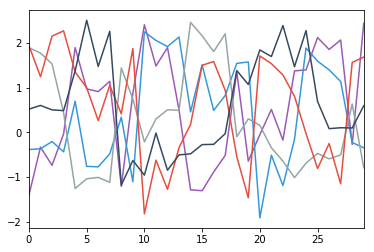

In [107]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for i, arr in enumerate(np.split(ary = predictions_list[normal_test_example_index]["Y"].flatten(), indices_or_sections = len(UNLABELED_CSV_COLUMNS), axis = 0)):
    sns.tsplot(arr, color = flatui[i%len(flatui)] )

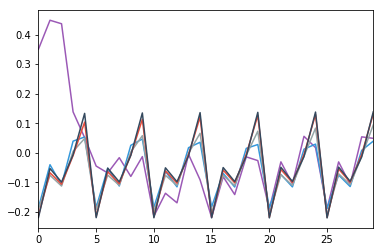

In [108]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for i, arr in enumerate(np.split(ary = predictions_list[normal_test_example_index]["predictions"].flatten(), indices_or_sections = len(UNLABELED_CSV_COLUMNS), axis = 0)):
    sns.tsplot(arr, color = flatui[i%len(flatui)] )

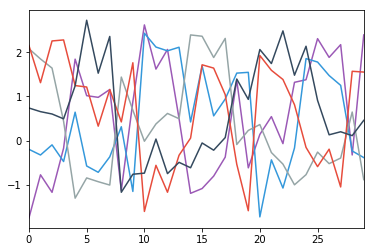

In [109]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for i, arr in enumerate(np.split(ary = predictions_list[normal_test_example_index]["error"].flatten(), indices_or_sections = len(UNLABELED_CSV_COLUMNS), axis = 0)):
    sns.tsplot(arr, color = flatui[i%len(flatui)] )

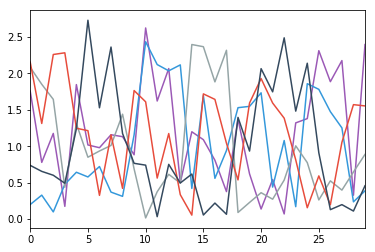

In [110]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for i, arr in enumerate(np.split(ary = predictions_list[normal_test_example_index]["absolute_error"].flatten(), indices_or_sections = len(UNLABELED_CSV_COLUMNS), axis = 0)):
    sns.tsplot(arr, color = flatui[i%len(flatui)] )

### Anomalous Example

In [111]:
anomalous_test_example_index = np.argmax(arr_test_labels == '1')

In [112]:
predictions_list[anomalous_test_example_index]

{'Y': array([[ 1.17870308e+01,  3.87631607e+00, -1.45760973e+01,
          1.91476492e+00,  4.71515271e+01],
        [ 2.00888492e+01, -1.75728503e+01,  1.46990261e+01,
         -1.76734627e+01, -1.58839203e+01],
        [-4.06054004e+01,  1.69770580e+01, -3.41193093e+01,
          6.53746557e+00, -1.00599301e+01],
        [-1.66297525e+01,  1.57614119e+01,  7.75398965e+00,
         -2.10134510e+01, -3.31916973e+00],
        [ 1.35110794e+00,  6.91802642e+00,  1.59876692e+00,
         -1.67312634e+01,  2.66604727e+01],
        [ 3.92571553e+01, -2.15943886e+01,  3.73009537e+01,
          4.16107197e+00, -2.08745225e+01],
        [ 6.22161418e+00, -4.35715107e+00,  2.93251898e+00,
          1.89985938e+01, -1.08423242e+01],
        [ 9.11095739e+00,  5.89927887e+00,  1.89358157e+01,
          8.03710320e+00, -1.77026779e+01],
        [ 2.78963177e+01,  1.52319725e+01, -1.18698518e+01,
          1.66108994e+01, -3.69317408e+00],
        [ 1.15257110e+00,  4.59728750e-01,  1.10502438e+00,

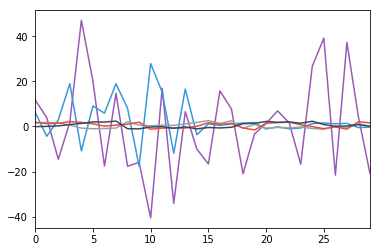

In [113]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for i, arr in enumerate(np.split(ary = predictions_list[anomalous_test_example_index]["Y"].flatten(), indices_or_sections = len(UNLABELED_CSV_COLUMNS), axis = 0)):
    sns.tsplot(arr, color = flatui[i%len(flatui)] )

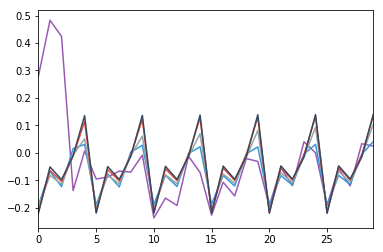

In [114]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for i, arr in enumerate(np.split(ary = predictions_list[anomalous_test_example_index]["predictions"].flatten(), indices_or_sections = len(UNLABELED_CSV_COLUMNS), axis = 0)):
    sns.tsplot(arr, color = flatui[i%len(flatui)] )

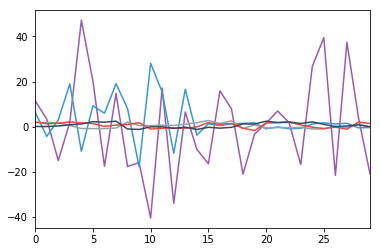

In [115]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for i, arr in enumerate(np.split(ary = predictions_list[anomalous_test_example_index]["error"].flatten(), indices_or_sections = len(UNLABELED_CSV_COLUMNS), axis = 0)):
    sns.tsplot(arr, color = flatui[i%len(flatui)] )

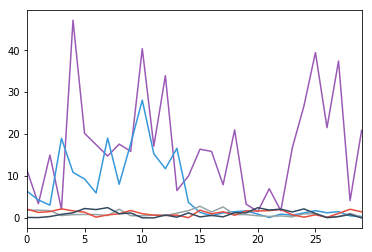

In [116]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for i, arr in enumerate(np.split(ary = predictions_list[anomalous_test_example_index]["absolute_error"].flatten(), indices_or_sections = len(UNLABELED_CSV_COLUMNS), axis = 0)):
    sns.tsplot(arr, color = flatui[i%len(flatui)] )